In [1]:
!pip install Sastrawi


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import nltk
nltk.download('stopwords')
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## A. Crawling Data

In [2]:
# Membaca file Excel
file_path = 'ulasanbibitfix2022.xlsx'
df= pd.read_excel(file_path)

## B. Labeling

In [3]:
label = []
for index, row in df.iterrows():
  if row["score"] == 1 or row["score"] == 2:
    label.append(0) #negatif
  else :
    label.append(1) #positif

df["label"] = label

In [4]:
df['label'].value_counts()

label
1    8036
0    2921
Name: count, dtype: int64

In [5]:
output_file_path = "pelabelan.xlsx"
df.to_excel(output_file_path, index=False)
print("Output saved to:", output_file_path)

Output saved to: pelabelan.xlsx


In [6]:
# Data yang diberikan
label_counts = {
    "1": 8036,
    "0": 2921
}

# Hitung total data
total = sum(label_counts.values())

# Hitung persentase setiap label
percentages = {label: (count / total) * 100 for label, count in label_counts.items()}

# Format hasil
percentages


{'1': 73.34124304097837, '0': 26.65875695902163}

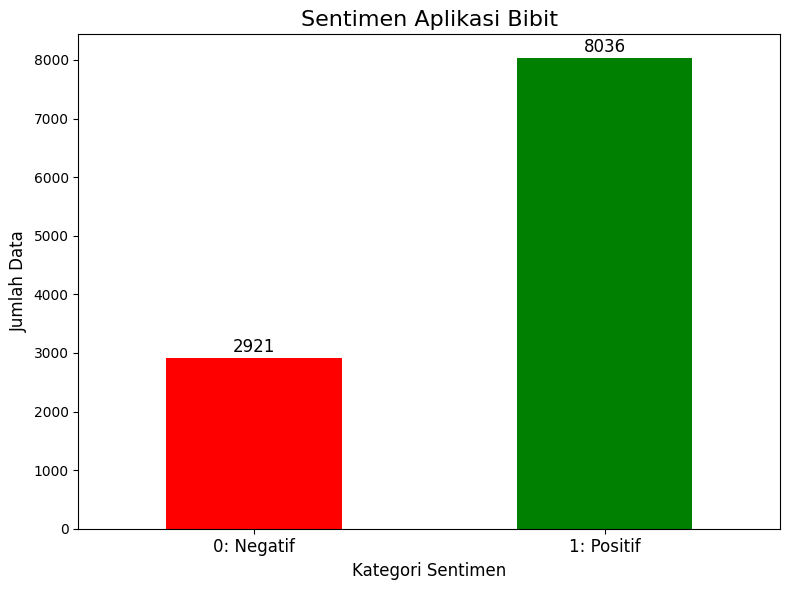

In [8]:
#VISUAL PELABELAN
# Data contoh
sentimen_data = pd.Series({"0": 2921,"1": 8036})

# Plot data
ax = sentimen_data.plot(kind='bar', color=['red', 'green'], figsize=(8, 6))

# Tambahkan keterangan untuk setiap bar
for i, (label, count) in enumerate(sentimen_data.items()):
    ax.text(i, count + 100, f'{count}', ha='center', fontsize=12)  # Tambahkan jumlah di atas bar

# Tambahkan keterangan sumbu x
ax.set_xticklabels(['0: Negatif', '1: Positif'], rotation=0, fontsize=12)

# Judul dan label
plt.title("Sentimen Aplikasi Bibit", fontsize=16)
plt.xlabel("Kategori Sentimen", fontsize=12)
plt.ylabel("Jumlah Data", fontsize=12)

# Tampilkan plot
plt.tight_layout()
plt.show()


In [9]:
#Kolom yang dibutuhkan untuk pembersihan
df= df[['reviewId', 'content', 'label']]

## C. Preprocessing Teks

CASEFOLDING

In [10]:
# Casefolding
# Mengubah text menjadi lower
df['Casefolding'] = df['content'].str.lower()

CLEANING

In [11]:
#Cleaning
##Pada tahap ini menghapus karakter-karakter spasial yang tidak memberikan pengaruh terhadap proses klasifikasi sentimen,
#seperti menghapus hastag (#), mention (@), link, emoticon, tanda baca koma (,), titik (.), dan karakter angka.

# Fungsi untuk membersihkan Ulasan dengan menghapus karakter dan elemen yang tidak diinginkan
def remove(Casefolding):
    if not isinstance(Casefolding, str):  # Cek apakah input berupa string
        return ""

    # Menghapus tab, new line, dan backslashes
    Casefolding = Casefolding.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")

    # Menghapus mentions, tautan, dan hashtag
    Casefolding = ' '.join(re.sub(r"([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", Casefolding).split())

    # Menghapus URL yang tidak lengkap
    Casefolding = Casefolding.replace("http://", " ").replace("https://", " ")

    # Menghapus karakter khusus kecuali huruf, angka, dan spasi
    Casefolding = re.sub(r"[^a-zA-Z0-9\s]", "", Casefolding)

    # Menghapus emotikon menggunakan rentang Unicode untuk emotikon
    Casefolding = re.sub(r"["
                         u"\U0001F600-\U0001F64F"  # Emotikon wajah
                         u"\U0001F300-\U0001F5FF"  # Simbol dan objek
                         u"\U0001F680-\U0001F6FF"  # Transportasi dan simbol lainnya
                         u"\U0001F1E0-\U0001F1FF"  # Bendera negara
                         u"\U00002500-\U00002BEF"  # Simbol tambahan
                         u"\U00002702-\U000027B0"
                         u"\U000024C2-\U0001F251"
                         u"\U0001F926-\U0001FA9F"
                         u"\U0001F90C-\U0001F93F"
                         u"\U0001F600-\U0001F64F"
                         u"\U0001F900-\U0001F9FF"
                         u"\U0001FA70-\U0001FAFF"
                         "]+", "", Casefolding, flags=re.UNICODE)

    return Casefolding

# Menerapkan fungsi pembersihan pada Ulasan
df['Cleaning'] = df['Casefolding'].apply(lambda x: remove(x))

# Fungsi untuk menghapus angka dari Ulasan
def remove_number(Casefolding):
    return re.sub(r"\d+", "", Casefolding)

# Menerapkan fungsi remove_number pada Ulasan yang telah dibersihkan
df['Cleaning'] = df['Cleaning'].apply(remove_number)





**Normalisasi**

Tahap ini bertujuan untuk mengubah kalimat yang tidak baku atau
slang word menjadi kalimat baku 


In [12]:
#normalisasi
replacement_dict = {
    "gopaylok": "gopay",
    "gopaylinkaja": "gopay",
    "gopaygopay": "gopay",
    "googlee": "google",
    "widrawl": "withdraw",
    "widrawnya": "withdraw",
    "widthdraw": "withdraw",
    "witdhraw": "withdraw",
    "witdhrawyah": "withdraw",
    "witdraw": "withdraw",
    "witdrw": "withdraw",
    "withdrawl": "withdraw",
    "withdrawprosesnya": "withdraw",
    "wktunya": "waktu",
    "tiati": "hati-hati",
    "tihati": "hati-hati",
    "tercuan": "cuan",
    "terdetek": "terdeteksi",
    "terdftar": "terdaftar",
    "terdftr": "terdaftar",
    "terdowload": "terunduh",
    "semuax": "semua",
    "semuaa": "semua",
    "semuanyesel": "semua menyesal",
    "semuasaat": "semua saat",
    "jago": "jago",
    "jagobank": "jago",
    "nabungg": "nabung",
    "nabungga": "nabung",
    "nabungmudahh": "nabung",
    "nabungnya": "nabung",
    "nabungpenarikan": "nabung penarikan",
    "nabungperbulan": "nabung bulanan",
    "raguragu": "ragu",
 'lanjutin':'lanjut',
 'prosea': 'proses',
 'Aperd': 'aplikasi',
 'jaring':'jaringan','jg':'juga',
 'Bagaimanadaftarnya': 'Bagaimana daftarnya',
 'Debest': 'terbaik',
 'adminkomisipencairan': 'admin komisi pencairan',
 'adminnya': 'admin',
 'custemer service':'cs',
 'ngga':'tidak',
 'aja': 'saja',
 'csnya':'cs',
 'tambahin':'tambah',
 'respone':'respon',
 'selfie':'foto',
 'alikas': 'aplikasi',
 'amam': 'aman',
 'lamajadi':'lama',
 'amanterpercaya': 'aman terpercaya',
 'amazing': 'menakjubkan',
 'apapelayanannya': 'apa pelayanan',
 'apk': 'aplikasi',
 'apl': 'aplikasi',
 'ribetnya':'susah',
 'bagusnyaman':'bagus',
 'rekomended':'rekomen',
 'aplication': 'aplikasi',
 'aplikasj': 'aplikasi',
 'apliksih': 'aplikasi',
 'apo': 'aplikasi',
 'add':'tambah',
 'rekomend':'rekomen',
 'app': 'aplikasi',
 'appl': 'aplikasi',
 'applikasi': 'aplikasi',
 'apps': 'aplikasi',
 'account':'akun',
 'adain':'mengadakan',
 'awesom': 'mengagumkan',
 'awesome': 'mengagumkan',
 'back': 'kembali',
 'bad': 'buruk',
 'bagi': 'untuk',
 'evet':'event',
 'bagusgampang': 'bagus gampang',
 'bagussangat': 'bagus sangat',
 'bagusssss': 'bagus',
 'baguuuusss': 'bagus',
 'baiknamun': 'baik namun',
 'bangeeett': 'sangat',
 'banget': 'sekali',
 'bangetbisa': 'sangat bisa',
 'bangett': 'sangat',
 'bangettt': 'sangat',
 'bangetttt': 'sangat',
 'bberapa': 'berapa',
 'bbrp': 'beberapa',
 'belom': 'belum',
 'benartrjamin': 'benar terjamin',
 'beneerrrr': 'benar',
 'bener': 'benar',
 'beneran':'bener',
 'benerin': 'benarkan',
 'beratmasa': 'berat masa',
 'berbagiku': 'berbagi',
 'beres': 'selesai',
 'bergunaa': 'berguna',
 'bermanfaatnya': 'manfaat',
 'best': 'terbaik',
 'bestie': 'teman',
 'besttt': 'terbaik',
 'bgtt': 'sangat',
 'bgus': 'bagus',
 'bguss': 'bagus',
 'biasa': 'biaya',
 'bibitdan': 'bibit dan',
 'bilamana': 'kapan',
 'bilang': 'katakan',
 'bingungfree': 'bingung free',
 'bisa': 'dapat',
 'bit bit': 'Bibit',
 'bka': 'buka',
 'blg': 'bilang',
 'bljr': 'belajar',
 'blm': 'belum',
 'bln': 'bulan',
 'blum': 'belum',
 'bnyak': 'banyak',
 'bonusnua': 'bonusnya',
 'brani': 'berani',
 'bro': 'saudara',
 'brp': 'berapa',
 'btas': 'batas',
 'buaguuus': 'bagus',
 'buat': 'kepada',
 'buntung': 'rugi',
 'cairin': 'mencairkan',
 'cairnya': 'pencairannya',
 'cancel': 'batalkan',
 'cape': 'lelah',
 'capek': 'lelah',
 'card': 'kartu',
 'cek': 'periksa',
 'click': 'klik',
 'cobacoba': 'mencoba',
 'cocok': 'sesuai',
 'code': 'kode',
 'complain': 'mengeluh',
 'confirm': 'konfirmasi',
 'connection': 'koneksi',
 'crash': 'gagal',
 'creating': 'membuat',
 'cuan': 'uang',
 'cuma': 'hanya',
 'cepet':'cepat',
 'curhat': 'curahan hati',
 'dapet': 'dapat',
 'debest': 'terbaik',
 'delete': 'hapus',
 'depann': 'depan',
 'top':'terbaik',
 'deposit': 'setoran',
 'dg': 'dengan',
 'diarahkanoleh': 'diarahkan oleh',
 'difficult': 'sulit',
 'diliat': 'dilihat',
 'diprosesbintang': 'diproses bintang',
 'dlu': 'dulu',
 'donglotnya': 'download',
 'donload': 'download',
 'donlod': 'download',
 'donlwlod': 'download',
 'dopet': 'dompet',
 'down load': 'download',
 'dpt': 'dapat',
 'dr': 'dari',
 'drpd': 'daripada',
 'duit': 'uang',
 'dwnld': 'download',
 'dwolod': 'unduh',
 'emang': 'memang',
 'eror': 'error',
 'everything': 'segala sesuatu',
 'excellent': 'luar biasa',
 'experience': 'pengalaman',
 'fast': 'cepat',
 'features': 'fitur',
 'fix': 'perbaiki',
 'thn':'tahun',
 'ampe':'sampai',
 'ampir':'hampir',
 'system':'sistem',
 'aktifin':'aktif',
 'akademis':'akademik',
 'akaun':'akun',
 'loadingnya':'loading',
 'advisornya':'advisor',
 'admint':'admin',
 'gimana':'bagaimana',
 'admind':'admin',
 'adminya':'admin',
 'fixing': 'perbaiki',
 'force close': 'paksa tutup',
 'full': 'sepenuhnya',
 'g': 'tidak',
 'ga': 'tidak',
 'gak': 'tidak',
 'gangerti': 'tidak mengerti',
 'gc': 'tidak',
 'gimna': 'bagaimana',
 'gini': 'begini',
 'gk': 'tidak',
 'mikir':'berpikir',
 'gercep':'cepat',
 'gokil': 'keren',
 'galama':'tidak lama',
 'good': 'bagus',
 'gede':'besar',
 'gratis': 'tidak lagi gratis',
 'great': 'hebat',
 'greatest': 'hebat',
 'orangorang':'orang',
 'gtu': 'begitu',
 'gua': 'saya',
 'gubris': 'memedulikan',
 'gud': 'bagus',
 'gw': 'saya',
 'happy': 'bahagia',
 'hapusz': 'hapus',
 'hariorderan': 'hari orderan',
 'hasiljadi': 'hasil jadi',
 'hbis': 'habis',
 'helpful': 'membantu',
 'helpfull': 'membantu',
 'helpfully': 'membantu',
 'hp': 'ponsel',
 'hri': 'hari',
 'hrs': 'harus',
 'ig': 'instagram',
 'infestasi': 'investasi',
 'info': 'informasi',
 'informasi': 'informasi',
 'intetnet':'internet',
 'inggin': 'ingin',
 'inpo': 'informasi',
 'instan': 'seketika',
 'instant': 'seketika',
 'inves': 'investasi',
 'invest':'investasi',
 'jadiburuan': 'jadi buruan',
 'jangn': 'jangan',
 'jd': 'jadi',
 'jgn': 'jangan',
 'jt': 'juta',
 'jugabiar': 'juga biar',
 'jugasudah': 'juga sudah',
 'karna': 'karena',
 'kasi': 'beri',
 'kayak': 'seperti',
 'konek':'koneksi',
 'kecewa': 'mengecewakan',
 'kecewabiaya': 'kecewa biaya',
 'kedeban': 'kedepan',
 'kedpnnya': 'ke depannya',
 'kemaren': 'kemarin',
 'kenpa': 'kenapa',
 'kereeenn': 'keren',
 'keren': 'keren',
 'kmarin': 'kemarin',
 'kmna': 'kemana',
 'knpa': 'kenapa',
 'kodereferal': 'kode referal',
 'krennnnn': 'keren',
 'krn': 'karena',
 'ksini': 'kesini',
 'ku': 'saya',
 'kumplit': 'lengkap',
 'kurang cukup': 'kurang',
 'kyak': 'seperti',
 'kaya':'seperti',
 'kayak':'seperti',
 'lagi': 'sedang',
 'lagikalo': 'lagi kalau',
 'lainya': 'lainnya',
 'lamaaa': 'lama',
 'laamaaaa':'lama',
 'lamaaaaaaa': 'lama',
 'lamakejadian': 'lama kejadian',
 'lambattt': 'lambat',
 'lancaar': 'lancar',
 'lancarpilih': 'lancar pilih',
 'legalbibit': 'legal bibit',
 'lelet': 'lambat',
 'lemot': 'lambat',
 'lg': 'sedang',
 'lgsg': 'langsung',
 'liat': 'lihat',
 'like': 'suka',
 'log in': 'masuk',
 'login': 'masuk',
 'logout': 'keluar',
 'love': 'suka',
 'luama': 'lama',
 'lucuu': 'lucu',
 'maduk': 'masuk',
 'maen': 'main',
 'makai': 'pakai',
 'males': 'malas',
 'mamtap': 'mantap',
 'manager': 'manajer',
 'mantab': 'mantap',
 'mantabb': 'mantap',
 'mantabbb': 'mantap',
 'mantabbbb': 'mantap',
 'mantao': 'mantap',
 'mantap': 'mantap',
 'mantappp': 'mantap',
 'mantappppp': 'mantap',
 'mantaps': 'mantap',
 'mantapue': 'mantap',
 'mantul': 'mantap',
 'matiin': 'mati',
 'kenatipu':'kena tipu',
 'message': 'pesan',
 'mau': 'ingin',
 'mayan': 'lumayan',
 'membagongkan': 'membingungkan',
 'mendingg': 'mending',
 'menggangu': 'mengganggu',
 'menyelesaikn': 'menyelesaikan',
 'menyukai': 'suka',
 'mesti': 'harus',
 'mindset': 'pola pikir',
 'mnungguterlalu': 'menunggu terlalu',
 'mnyukai': 'menyukai',
 'msuk': 'masuk',
 'muda': 'mudah',
 'mudah dipergunakan': 'mudah digunakan',
 'mudahmudah': 'semoga',
 'mudahmudahan': 'semoga',
 'muga': 'semoga',
 'mulu': 'terus',
 'naaaiiissssss': 'bagus',
 'nasabh': 'nasabah',
 'ndak': 'tidak',
 'newbie': 'pemula',
 'ngak': 'tidak',
 'ngambil': 'mengambil',
 'ngasih': 'memberikan',
 'ngedadak': 'mendadak',
 'ngelag': 'lag',
 'nggak': 'tidak',
 'nice': 'baik',
 'niceeeee': 'baik',
 'nilai': 'nilai',
 'norek': 'nomor rekening',
 'ntapss': 'mantap',
 'ntu': 'itu',
 'nyambungin': 'menyambungkan',
 'nyatanya': 'kenyataannya',
 'nyesel': 'menyesal',
 'nyoba': 'mencoba',
 'nyuruh': 'menyuruh',
 'okkk': 'oke',
 'onlinee': 'online',
 'orangsukses': 'orang sukses',
 'org': 'orang',
 'pahambibit': 'paham bibit',
 'pake': 'gunakan',
 'pdahal': 'padahal',
 'pdhal': 'padahal',
 'pembayan': 'pembayaran',
 'pembayaranonline': 'pembayaran online',
 'pembeliantopupnya': 'pembelian topupnya',
 'penampunguntuk': 'penampung untuk',
 'pencairanlama': 'pencairan lama',
 'pengen': 'ingin',
 'penguna': 'pengguna',
 'penipu': 'penipuan',
 'penjualanmakin': 'penjualan semakin',
 'perbayak': 'perbanyak',
 'percepar': 'percepat',
 'percepatkrna': 'percepat karena',
 'percepet': 'percepat',
 'pinjol': 'pinjaman online',
 'pke': 'pakai',
 'pnarikan': 'penarikan',
 'pndapatan': 'pendapatan',
 'pokoknya': 'intinya',
 'poto': 'foto',
 'produkproduk': 'produk',
 'problem':'masalah',
 'raksadana': 'reksadana',
 'rb': 'ribu',
 'rbu': 'ribu',
 'read': 'baca',
 'recomended': 'rekomendasi',
 'recommended': 'rekomendasi',
 'rekom':'rekomendasi',
 'referar': 'referal',
 'reff': 'referal',
 'rek': 'rekening',
 'rekenig': 'rekening',
 'rekomendasi': 'rekomendasi',
 'rekomendet': 'rekomendasi',
 'reksa': 'reksadana',
 'reksa dana': 'reksadana',
 'reksadan': 'reksadana',
 'reksadananya': 'reksadana',
 'rentan': 'rentang',
 'resiko': 'risiko',
 'responbanyak': 'respon banyak',
 'reveral': 'referal',
 'ribet': 'rumit',
 'sangaaaaaat': 'sangat',
 'sanggaaaaat': 'sangat',
 'sayabga': 'tidak',
 'sbg': 'sebagai',
 'sdah': 'sudah',
 'sdh': 'sudah',
 'sekian': 'tertentu',
 'semoga': 'semoga',
 'seribet': 'ribet',
 'setting': 'pengaturan',
 'setujuhui': 'setujui',
 'siapmendapatkan': 'siap mendapatkan',
 'skrng': 'sekarang',
 'smoga': 'semoga',
 'smp': 'sampai',
 'smpe': 'sampai',
 'smua': 'semua',
 'soalnya': 'karena',
 'spt': 'seperti',
 'sptp': 'seperti',
 'start': 'mulai',
 'stlah': 'setelah',
 'stts': 'status',
 'suka': 'suka',
 'sukses': 'berhasil',
 'sungguh': 'sangat',
 'suport': 'dukung',
 'syaabaaarrrr': 'sabar',
 'syabaaaaarrr': 'sabar',
 'tak': 'tidak',
 'tamah': 'tambah',
 'tambahkanfitur': 'tambahkan fitur',
 'taro': 'taruh',
 'tdak': 'tidak',
 'tdk': 'tidak',
 'temanteman': 'teman',
 'terbaikkalau': 'terbaik kalau',
 'terbaiq': 'terbaik',
 'terpercayan': 'terpercaya',
 'terpercayasaya': 'terpercaya saya',
 'teruma': 'terutama',
 'tfer': 'transfer',
 'tgl': 'tanggal',
 'the best': 'terbaik',
 'tidam': 'tidak',
 'tidk': 'tidak',
 'tnpa': 'tanpa',
 'tolong': 'mohon',
 'tp': 'tapi',
 'tpi': 'tapi',
 'trjual': 'terjual',
 'trnyta': 'ternyata',
 'trus': 'terus',
 'tsb': 'tersebut',
 'tuliasan': 'tulisan',
 'uangx': 'uang',
 'uangy': 'uang',
 'udah': 'sudah',
 'udh': 'sudah',
 'uninstal': 'uninstall',
 'upgrade': 'peningkatan',
 'useful': 'berguna',
 'utk': 'untuk',
 'verfikasi': 'verifikasi',
 'verif': 'verifikasi',
 'verivikasi': 'verifikasi',
 'very': 'sangat',
 'via': 'melalui',
 'yg': 'yang',
 'wokey':'oke',
 'worthit':'layak',
 'wort':'layak',
'worth':'layak',
'work':'kerja',
"view":'lihat',"virifikasi":'verifikasi',"viturnya":'fitur',
'vitur':'fitur','wallet':'dompet','walletnya':'dompet',
'walletupdate':'dompet',
'verifikasipdhl':'verifikasi',
'verify':'verifikasi',
'verifykarena':'verifikasi',
'verikasi':'verifikasi',
'verikasinya':'verifikasi',
'verivikasinya':'verifikasi',
'vertifikasi':'verifikasi',
'verykasi':'verifikasi',
'verevikasikan':'verifikasi',
'verevikasiwa':'verifikasi',
'varian':'variasi',
'variatif':'variatif',
'users':'pengguna',
'user':'pengguna',
'urgen':'mendesak',
'urgent':'mendesak',
"upload":'unggah',
'update':'pembaruan',
'updatean':'pembaruan',
'updatecapek':'pembaruan',
'updatenya':'pembaruan',
'updatereset':'pembaruan',
'updet':'pembaruan',
'upgradeke':'pembaruan',
'upgrate':'pembaruan',
'upgride':'pembaruan',
'untungny':'untung',
'untungruginya':'untung',
'untungtabur':'untung',
'unt':'untuk',
'untk':'untuk',
'untu':'untuk',
'untuj':'untuk',
'uninstaldaftar':'uninstall',
'uninstalga':'uninstall',
'uninstall':'uninstall',
'unistal':'uninstall',
'uininstal':'uninstall',
'uagnya':'uang',
'uang':'uang',
'uangbibit':'uang',
'uangg':'uang',
'uangkalian':'uang',
'uangobligasi':'uang',
'uangobligasisaham':'uang',
'uangpengelolaan':'uang',
'uangrakyat':'uang',
'uangsangat':'uang',
'uangtambah':'uang',
'uanguntung':'uang',
'tutorial':'tutor',
'turunin':'turun',
'tulisanya':'tulisan',
'tulisanny':'tulisan',
'tsmpilan':'tampilan',
'try':'coba',
'trust':'percaya',
'trusted':'percaya',
'treding':'tren',
'tren':'tren',
'trending':'tren',
'transferanya':'transfer',
'transfernyabulanan':'transfer',
'transferpencairan':'transfer',
'transfr':'transfer',
'trasfer':'transfer',
'tranfaran':'transparan',
'tranfer':'transfer',
'tranfernya':'transfer',
'trankasi':'transaksi',
'transaksi':'transaksi',
'transaksil':'transaksi',
'transaksimaksudnya':'transaksi',
'transaksimenabung':'transaksi',
'trading':'perdagangan',
'traiding':'perdagangan',
'tranding':'perdagangan',
'topupkan':'topup',
'topupnya':'topup',
'tools':'tool',
'tingkatin':'tingkat',
'toolsnya':'tool',
'tolonng':'tolong',
'tida':'tidak',
"terverivikasi":'verifikasi',
'tipualon':'tipu',
'tiputipu':'tipu',
'teroooossss':'terus',
'terpercayadaftar':'terpercaya',
'terpercayasehingga':'terpercaya',
'terpercya':'terpercaya',
'tersimple':'sederhana',
'tersmpan':'tersimpan',
'tertariksekarang':'tertarik',
'terupdate':'pembaruan',
"terinstall":'install',
'turlisannya':'tulisan',
'undangundang':'undang',
'ulogin':'masuk',
'terimah':'terima',
'teknologisemua':'teknologi',
'teknikal':'teknis',
'techical':'teknis',
'tanamnnya':'tanam',
'tampilanya':'tampil',
'tambahain':'tambah',
'tambahanin':'tambah',
'tambahib':'tambah',
'tambahlan':'tambah',
'tambain':'tambah',
'tambhin':'tambah',
'tabunganberjalan':'tabungan',
'tabungane':'tabungan',
'tabunganjamannow':'tabungan',
'tabungin':'menabung',
'tabunginkali':'menabung',
'syariahkarena':'syariah',	
'syariahnya':'syariah',
'syarataya':'syarat',
'syaratitu':'syarat',
'syaratya':'syarat',
'susa':'susah',
'susaah':'susah',
'susah':'susah',
'susahgk':'susah',
'susahh':'susah',
'susahin':'susah',
'susahseandainya':'susah',
'sussah':'susah',
'support':'dukungan',
'supportnya':'dukungan',
'supportnyasemoga':'dukungan',
'suksesbiar':'sukses',
'suksescuanbareng':'sukses',
'suksesmasukan':'sukses',
'sukser':'sukses',
'suka':'suka',
'sukaa':'suka',
'sukaak':'suka',
'sukadana':'suka',
'sukakk':'suka',
'sukasaya':'suka',
'sudahh':'sudah',
'sudak':'sudah',
'sudh':'sudah',
'sudha':'sudah',
'strees':'stres',
'stresjadi':'stres',
'stress':'stres',
'stresss':'stres',
'staffnya':'staff',
'staffpegawai':'staff',
'stabill':'stabil',
'spamm':'spam',
'solusisnyaa':'solusi',
'sistemnyamasa':'sistem',
'sistemnyamau':'sistem',
'sinkronize':'sinkron',
'simpen':'simpan',
'sham':'saham',
'tari':'tarik',
'sesuaibagus':'sesuai',
'sesuaidan':'sesuai',
'sesui':'sesuai',
'service':'servis',
'servicenya':'servis',
'seringkali':'sering',
'semogaa':'semoga',
'semogah':'semoga',
'semogga':'semoga',
'semonga':'semoga',
'semngat':'semangat',
'semingguitu':'seminggu',
'seminggupadahal':'seminggu',
'semnggu':'seminggu',
'semangaaat':'semangat',
'semangat':'semangat',
'semangatt':'semangat',
'semangt':'semangat',
'selsai':'selesai',
'selsaikan':'selesai',
'sell':'jual',
'sellbuy':'jual',
'sellu':'jual',
'selfinya':'foto',
'selfi':'foto',
'selesai':'selesai',
'selesaikandan':'selesai',
'selesaiselesai':'selesai',
'selesein':'selesai',
'selau':'selalu',
'selaiiinn':'selain',
'selallu':'selalu',
'selamat':'selamat',
'selamt':'selamat',
'sekolh':'sekolah',
'sekrang':'sekarang',
'sekrg':'sekarang',
'sekrng':'sekarang',
'seklai':'sekali',
'sekli':'sekali',
'sekatang':'sekarang',
'sekali':'sekali',
'sekalianstop':'sekalian',
'sejau':'sejauh',
'sejauhhh':'sejauh',
'seka':'sekarang',
'sekaliayo':'sekali',
'sekalicuma':'sekali',
'sekalideposit':'sekali',
'sekaligooddd':'sekali',
'sekaliproses':'sekali',
'sejahtera':'sejahtera',
'sejahterahkan':'sejahtera',
'sejahteramasadepan':'sejahtera',
'sejahtra':'sejahtera',
'seharihari':'sehari',
'sediihh':'sedih',
'sebenanrya':'sebenarnya',
'sebenernya':'sebenarnya',
'sebentar':'sebentar',
'seblm':'sebelum',
'sebulandiup':'sebulan diup',
'secepar':'secepat',
'scrup':'skrup',
'sd':'sudah',
'sdg':'sedang',
'sdgkan':'sedangkan',
'sdgkn':'sedangkan',
'sdhulai':'sudahulai',
'sdikityg':'sedikit yang',
'sbnrnya':'sebenarnya',
'sbnyak':'sebanyak',
'sbr':'seber',
'sbrnya':'sebenarnya',
'sbrp':'seberapa',
'sbulan':'sebulan',
'scalping':'scalping',
'save':'menyimpan',
'saving':'menyimpan',
'savings':'tabungan',
'saran':'saran',
'sarana':'sarana',
'saranin':'sarankan',
'sarankn':'sarankan',
'sanga':'sangat',
'sangan':'sangat',
'sangatembantu':'sangat membantu',
'sangatsangat':'sangat',
'sangatt':'sangat',
'sangatta':'sangat',
'sangattt':'sangat',
'sangay':'sangat',
'sangit':'sangat',
'sangkat':'sangat',
'sampa':'sampah',
'sampahwd':'sampah',
'sambungin':'sambung',
'saldoadmincs' : 'saldo admin cs',
'saldoo' : 'saldo',
'saldoyg' : 'saldo yang',
'sales' : 'penjualan',
'salin' : 'salin',
'salut' : 'salut',
'sama' : 'sama',
'samapai' : 'sampai',
'salagunakan' : 'salahgunakan',
'saham':'saham',
'sahamdarisekarang':'saham',
'sahamjadi':'saham',
'sahamlambat':'saham',
'sahammau':'saham',
'sahamobligasi':'saham',
'sahamproses':'saham',
'sahamsetelab':'saham',
'sahamthanks':'saham',
'sabar':'sabar',
'sabarin':'sabarkan',
'sabarpasti':'sabar',
'satisfaction':'kepuasan',
'satsetpencairan':'cepat pencairan',
'rutinbukan':'rutin',	
'rutinin':'rutin',	
'rutinuntuk':'rutin',
'rusakdeposit':'rusak',
'rupiahpayah':'rupiah',
'robo':'robot',
'robonya':'robot',
'aktf':'aktif',
'aktifcuan':'aktif',
'aktive':'aktif',
'alasanya':'alasan',
'analisa':'analisis',
'amanah':'amanah',
'amanahamin':'amanahkan',
'amanat':'amanat',
'amandemen':'amandemen',
'amanterimakasih':'amanat terima kasih',
'antarmuka':'antarmuka',
'antipati':'antipati',
'apes':'apes',
'apikasi':'aplikasi',
'apiksi':'aplikasi',
'apklikasi':'aplikasi',
'apklisi':'aplikasi',
'apkny':'aplikasinya',
'apknya':'aplikasinya',
'apkyank':'aplikasi yang',
'aplikaei':'aplikasi',
'aplikasi':'aplikasi',
'aplikasibya':'aplikasi',
'aplikasidisuruh':'aplikasi disuruh',
'aplikasih':'aplikasi',
'aplikasihnya':'aplikasinya',
'aplikasin':'aplikasi',
'aplikasinnya':'aplikasinya',
'aplikasiny':'aplikasinya',
'aplikasinyaa':'aplikasinya',
'aplikasinyacuma':'aplikasinya cuma',
'aplikasinyadan':'aplikasinya dan',
'aplikasinyagambar':'aplikasinya gambar',
'aplikasinyagimana':'aplikasinya gimana',
'aplikasinyaproses':'aplikasinya proses',
'aplikasinyasangat':'aplikasinya sangat',
'aplikasiya':'aplikasi',
'apliksi':'aplikasi',
'aplilasi':'aplikasi',
'aplkasi':'aplikasi',
'apllikasi':'aplikasi',
'aplnya':'aplikasinya',
'application':'aplikasi',
'appnya':'aplikasinya',
'approv':'approve',
'approve':'approve',
'approvetidak':'approve tidak',
'appsnya':'aplikasinya',
'apr':'april',
'apss':'apps',
'apudete':'update',
'apus':'hapus',
'arahannyakalau':'arahnya kalau',
'asli':'asli',
'asliii':'asli',
'asliny':'aslinya',
'aslinyatp':'aslinya tapi',
'aslipdhal':'asli padahal',
'autentikasi':'autentikasi',
'authenticator':'autentikator',
'auto':'auto',
'autodebet':'autodebet',
'autodebitjadwal':'autodebit jadwal',
'autoinvest':'autoinvest',
'autopay':'autopay',
'backgriund':'background',
'background':'background',
'bacot':'bacot',
'asistantnya':'asistennya',
'bagibagi':'bagi',
'bagis':'bagus',
'bags':'bagus',
'bagsdengan':'bagus',
'bagua':'bagus',
'bagus':'bagus',
'bagusbanyak':'bagus banyak',
'bagusbibit':'bagus bibit',
'bagusbisa':'bagus bisa',
'bagusbtw':'bagus ',
'baguscocok':'bagus cocok',
'bagusdengan':'bagus dengan',
'bagusdimohon':'bagus dimohon',
'bagusfiturnya':'bagus fiturnya',
'bagusgunakan':'bagus gunakan',
'bagushanya':'bagus hanya',
'bagusin':'bagus',
'bagusmengenai':'bagus mengenai',
'bagusmeski':'bagus meski',
'baguspadahal':'bagus padahal',
'baguss':'bagus',
'bagussbintang':'bagus ',
'bagusscocok':'bagus cocok',
'bagussekali':'bagus sekali',
'bagusselama':'bagus selama',
'bagussemoga':'bagus semoga',
'bagussetakan':'bagus ',
'bagusss':'bagus',
'bagustambahkan':'bagus tambahkan',
'bagustampilan':'bagus tampilan',
'bagustolong':'bagus tolong',
'bagustransaksi':'bagus transaksi',
'bagusuntuk':'bagus untuk',
'bagusutk':'bagus ',
'baguswalopun':'bagus walaupun',
'baguus':'bagus',
'baik':'baik',
'baikaku':'baik aku',
'baikbaik':'baik',
'baikdan':'baik dan',
'baiklagi':'baik lagi',
'baiksangat':'baik sangat',
'baiksaya':'baik saya',
'baiktapi':'baik tapi',
'balas':'balas',
'bales':'balas',
'balesannya':'balasan',
'balik':'balik',
'balikin':'kembalikan',
'bangatgk':'sangat',
'banged':'sangat',
'bangeeettt':'sangat',
'bangeett':'sangat',
'banget':'sangat',
'bangetblm':'belum sangat',
'bangetdan':'dan sangat',
'bangetgabung':'sangat bergabung',
'bangetgiliran':'sangat giliran',
'bangethitung':'sangat menghitung',
'bangetkarena':'sangat karena',
'bangetkasih':'sangat memberi',
'bangetkatanya':'sangat katanya',
'bangetmembantu':'sangat membantu',
'bangetmungkin':'sangat mungkin',
'bangetninggalin':'sangat meninggalkan',
'bangetsaya':'sangat',
'bangettbeda':'sangat berbeda',
'bangettertulis':'sangat tertulis',
'bangetterus':'sangat terus',
'bangetttttt':'sangat',
'bangke':'bangke',
'bangkeudh':'bangke udah',
'bankada':'ada bank',
'bankatm':'atm bank',
'bankbank':'bank',
'bankcelengan':'bank celengan',
'banking':'perbankan',
'bankjago':'bank',
'banksusah':'bank susah',
'banksy':'bank syariah',
'bankyang':'bank yang',
'bantuanjangan':'jangan bantu',
'bantuanny':'bantu',
'bantuanya':'bantu',
'bantuin':'bantu',
'bantuvrakyat':'bantu untuk rakyat',
'banyakaplikasinya':'banyak aplikasi',
'banyakin':'banyakkan',
'banyakkapan':'banyak kapan',
'banyakkarna':'banyak karena',
'banyakkkk':'banyak sekali',
'banyakloading':'banyak loading',
'banyk':'banyak',
'baruaplikasi':'aplikasi baru',
'barubibit':'baru',
'baruh':'baru',
'barukurang':'baru kurang',
'barumudah':'baru mudah',
'barumulai':'baru mulai',
'barusan':'barusan',
'baruu':'baru',
'bawa':'bawa',
'bawah':'bawah',
'bayak':'banyak',
'bayang':'bayangkan',
'bayangin':'bayangkan',
'bayarin':'bayarkan',
'bayart':'bayar',
'belibet':'belibet',
'belicepet':'beli cepat',
'benerang':'beneran',
'benerann':'beneran',
'benerbener':'bener',
'benrran':'beneran',
'beraniin' : 'beranikan',
'berbedabeda' : 'berbeda',
'berbedamhon' : 'berbeda ',
'berbelitbelit' : 'berbelit-belit',
'berharisampai' : 'berhari sampai',
'berharihari' : 'berhari',
'berhariharikarena' : 'berhari karena',
'berhasilapk' : 'berhasil aplikasi',
'berhasildan' : 'berhasil dan',
'berhasill' : 'berhasil',
'berhasiltolong' : 'berhasil tolong',
'berhematdan' : 'berhemat dan',
'berhrap' : 'berharap',
'berifestasi' : 'berinovasi',
'berifikasi' : 'verifikasi',
'berinfestasi' : 'investasi',
'berinventasi' : 'investasi',
'berinves' : 'investasi',
'berinvest' : 'investasi',
'berinvestasiaplikasi' : 'investasi aplikasi',
'berinvestasimemulai' : 'investasi memulai',
'berinvestasimudahan' : 'investasi mudah',
'berinvestasirespon' : 'investasi respon',
'berinvestasithx' : 'investasi ',
'berinvetasi' : 'investasi',
'berdikari' : 'berdikari',
'berfikir' : 'berpikir',
'berkembangg' : 'berkembang',
'berkurangklo' : 'berkurang kalau',
'berlajar' : 'belajar',
'bermanfaa' : 'bermanfaat',
'bermanivestasi' : 'bermanfaat investasi',
'bermasalahh' : 'bermasalah',
'bermingguklau' : 'berminggu',
'bermingguminggu' : 'berminggu',
'beroprasi' : 'beroperasi',
'bersamamenua' : 'bersama menu',
'bertambahjangan' : 'bertambah jangan',
'bertangung' : 'bertanggung',
'bertanyasama' : 'bertanya sama',
'berteletele' : 'bertele',
'berulangulang' : 'berulang',
'besarbanyak' : 'besar banyak',
'besarkemungkinan' : 'besar kemungkinan',
'besoknta' : 'besok',
'bestt' : 'terbaik',
'bestttt' : 'terbaik',
'better' : 'terbaik',
'bgaus' : 'bagus',
'bget' : 'sangat',
'bgi' : 'bagi',
'biarin' : 'biarkan',
'biarpun' : 'biarpun',
'biasa' : 'biasa',
'biasaaaa' : 'biasa',
'biasabagi' : 'biasa bagi',
'biasabisa' : 'biasa bisa',
'biasagk' : 'biasa gak',
'biasasebar' : 'biasa sebar',
'big' : 'big',
'binggung' : 'bingung',
'bingit' : 'sangat',
'bingung' : 'bingung',
'bingungsekarang' : 'bingung sekarang',
'bio' : 'bio',
'biodata' : 'biodata',
'bisaa' : 'bisa',
'bisaand' : 'bisa',
'bisabisa' : 'bisa',
'bisabisanya' : 'bisa',
'bisabuat' : 'bisa buat',
'bisagk' : 'bisa',
'bisagmna' : 'bisa gimana',
'bisagokil' : 'bisa',
'bisah' : 'bisa',
'bisain' : 'bisa',
'bisakarna' : 'bisa karena',
'bisaselalu' : 'bisa selalu',
'bisaudh' : 'bisa ',
'bisauntung' : 'bisa untung',
'bisauplod' : 'bisa upload',
'blok' : 'blokir',
'blokcain' : 'blokir',
'blokir' : 'blokir',
'bluman' : 'belum',
'blummsuk' : 'belum masuk',
'bnget' : 'sangat',
'bngettt' : 'sangat',
'bngst' : 'sangat',
'bngt' : 'sangat',
'bngtfitur' : 'sangat fitur',
'bngtt' : 'sangat',
'bobol' : 'bobol',
'bobot' : 'bobot',
'bobrok' : 'bobrok',
'bocah' : 'bocah',
'bocil' : 'bocil',
'bodo' : 'bodoh',
'bodoh' : 'bodoh',
'bodohbuat' : 'bodoh buat',
'bodohin' : 'bodoh',
'bonusny' : 'bonusnya',
'bonusnyaampun' : 'bonusnya ampun',
'bonustaryonosupaya' : 'bonus',
'boong' : 'bohong',
'buang' : 'buang',
'buangbuang' : 'buang',
'buangettttini' : 'sangat',
'buangwktu' : 'buang waktu',
'buat' : 'buat',
'buay' : 'buat',
'budidayaduit' : 'budidaya duit',
'budidayakan' : 'budidayakan',
'bufering' : 'buffering',
'buffering' : 'buffering',
'buffring' : 'buffering',
'bug' : 'bug',
'bugnya' : 'bug',
'bugs' : 'bug',
'bukagak' : 'buka gak',
'bukagimana' : 'buka gimana',
'bukak' : 'buka',
'bukakamarin' : 'buka kemarin',
'bukalama' : 'buka lama',
'bukasaya' : 'buka saya',
'bukatulisan' : 'buka tulisan',
'bukti' : 'bukti',
'buktikanlan' : 'buktikan',
'buktikann' : 'buktikan',
'bulai' : 'bulan',
'bulan' : 'bulan',
'bulann' : 'bulan',
'bulannyathank' : 'bulan',
'bulansemoga' : 'bulan semoga',
'bungaflower' : 'bunga flower',
'bungane' : 'bunga',
'bunntung' : 'buntung',
'buntung' : 'buntung',
'bursakarena' : 'bursa karena',
'buru' : 'buru',
'buruh' : 'buruh',
'buruksaya' : 'buruk saya',
'business' : 'business',
'bussines' : 'business',
'bussinesjadinya' : 'business jadinya',
'butuhhhhhh' : 'butuh',
'buy' : 'beli',
'buying' : 'beli',
'caircair' : 'cair',
'cairjgn' : 'cair',
'cairkirain' : 'cair kirain',
'cairnyajualnya' : 'cair jualnya',
'cairpada' : 'cair pada',
'cait' : 'cair',
'cariin' : 'carikan',
'casback' : 'cashback',
'casbacknya' : 'cashback',
'casbcklumayan' : 'cashback lumayan',
'case' : 'case',
'caseback' : 'cashback',
'cash' : 'cash',
'cashbac' : 'cashback',
'cashbacck' : 'cashback',
'cashback' : 'cashback',
'cashbackaplikasi' : 'cashback aplikasi',
'cashbacknya' : 'cashback',
'cashbacknyarecomend' : 'cashback rekomen',
'cashbackrb' : 'cashback',
'cashbacksaiyo' : 'cashback',
'cashbackterbukti' : 'cashback terbukti',
'cashbak' : 'cashback',
'cashbeck' : 'cashback',
'castback' : 'cashback',
'ceklis' : 'ceklis',
'ceklist' : 'ceklist',
"balas": "bales",
  "balesannya": "balik",
  "balikin": "balikin",
  "bangatgk": "sangat",
  "bangeeettt": "sangat",
  "banget": "sangat",
  "bangetblm": "sangat",
  "bangetdan": "sangat",
  "bangetgabung": "sangat",
  "bangetgiliran": "sangat",
  "bangethitung": "sangat hitung",
  "bangetkarena": "sangat karena",
  "bangetkasih": "sangat ",
  "bangetkatanya": "sangat",
  "bangetmembantu": "sangat membantu",
  "bangetmungkin": "sangat mungkin",
  "bangetninggalin": "sangat",
  "bangetsaya": "sangat saya",
  "bangettbeda": "sangat beda",
  "bangettertulis": "sangat tertulis",
  "bangetterus": "sangat terus",
  "bangetttttt": "sangat",
  "banggain": "banggain",
  "bangke": "bangke",
  "bangkeudh": "bangke",
  "bankada": "bank ada",
  "bankatm": "bank atm",
  "bankbank": "bank bank",
  "bankcelengan": "bank celengan",
  "banking": "bank",
  "bankjago": "bank jago",
  "banksusah": "bank susah",
  "banksy": "bank",
  "bankyang": "bank",
  "bantuanjangan": "bantuan jangan",
  "bantuanny": "bantuan",
  "bantuanya": "bantuan",
  "bantuin": "bantuan",
  "bantuvrakyat": "bantu",
  "banyakaplikasinya": "banyak aplikasi",
  "banyakin": "banyakin",
  "banyakkapan": "banyak kapan",
  "banyakkarna": "banyak karena",
  "banyakkkk": "banyak",
  "banyakloading": "banyak loading",
  "banyk": "banyak",
  "baruaplikasi": "baru aplikasi",
  "barubibit": "baru",
  "baruh": "baru",
  "barukurang": "baru kurang",
  "barumudah": "baru mudah",
  "barumulai": "baru mulai",
  "barusan": "baru",
  "baruu": "baru",
  "bawa": "bawa",
  "bawah": "bawah",
  "bayak": "banyak",
  "bayang": "bayang",
  "bayangin": "bayang",
  "bayarin": "bayar",
  "bayart": "bayar",
  "belibet": "belibet",
  "belicepet": "beli cepat",
  "benerang": "benar",
  "benerann": "benar",
  "benerbener": "benar",
  "benrran": "benar",
  "beraniin": "berani",
  "berbedabeda": "berbeda",
  "berbedamhon": "berbeda",
  "berbelitbelit": "belit",
  "berharisampai": "berhari",
  "berharihari": "berhari",
  "berhariharikarena": "berhari",
  "berhasilapk": "berhasil aplikasi",
  "berhasildan": "berhasil ",
  "berhasill": "berhasil",
  "berhasiltolong": "berhasil tolong",
  "berhematdan": "berhemat ",
  "berhrap": "berharap",
  "berifestasi": "investasi",
  "berifikasi": "verifikasi",
  "berinfestasi": "investasi",
  "berinventasi": "investasi",
  "berinves": "investasi",
  "berinvest": "investasi",
  "berinvestasiaplikasi": "investasi aplikasi",
  "berinvestasimemulai": "investasi memulai",
  "berinvestasimudahan": "investasi mudah",
  "berinvestasirespon": "investasi respon",
  "berinvestasithx": "investasi",
  "berinvetasi": "investasi",
  "berdikari": "berdikari",
  "berfikir": "berfikir",
  "berkembangg": "berkembang",
  "berkurangklo": "berkurang",
  "berlajar": "belajar",
  "bermanfaa": "bermanfaat",
  "bermanivestasi": "investasi",
  "bermasalahh": "bermasalah",
  "bermingguklau": "berminggu ",
  "bermingguminggu": "berminggu minggu",
  "beroprasi": "operasi",
  "bersamamenua": "bersama menu",
  "duid": "duit",
  "duittidurin": "duit tidur",
  "dulua": "dulu",
  "duluan": "duluan",
  "duluannya": "duluan",
  "duludulu": "dulu",
  "duluih": "dulu",
  "dulukalua": "dulu kalau",
  "dulunanti": "dulu nanti",
  "dulupahami": "dulu paham",
  "dulusudah": "dulu sudah",
  "dulutop": "dulu",
  "eror": "error",
  "erorr": "error",
  "errorini": "error",
  "faedah": "manfaat",
  "ferivikasi": "verifikasi",
  "fitturnya": "fitur",
  "fitur": "fitur",
  "fiture": "fitur",
  "fiturfitur": "fitur",
  "fiturnya": "fitur",
  "fiturnyaa": "fitur",
  "fluktuasi": "fluktuasi",
  "fluktuatif": "fluktuatif",
  "focus": "fokus",
  "fokus": "fokus",
  "force": "force",
  "forever": "forever",
  "form": "formulir",
  "forma": "formulir",
  "formulir": "formulir",
  "fortofolio": "portfolio",
  "fortopolio": "portfolio",
  "foto": "foto",
  "fresh": "fresh",
  "fress": "fresh",
  "frendly": "friendly",
  "friendly": "friendly",
  "friendy": "friendly",
  "fuull": "full",
  "gaada": "tidak ada",
  "gaakan": "tidak akan",
  "gabakal": "tidak bakal",
  "gabikin": "tidak bikin",
  "gabisa": "tidak bisa",
  "gabisaberkali": "tidak bisa berkali",
  "gabung": "gabung",
  "gabut": "gabut",
  "gacocok": "tidak cocok",
  "gacor": "gacor",
  "gada": "tidak ada",
  "gadapat": "tidak dapat",
  "gaessskenapa": "kenapa",
  "gagagal": "gagal",
  "gagal": "gagal",
  "gagalaneh": "gagal aneh",
  "gagalkatanya": "gagal katanya",
  "gagalkonyol": "gagal konyol",
  "gagalmencobalahgajadi": "gagal mencoba",
  "gaje": "tidak jelas",
  "gajelas": "tidak jelas",
  "gajelaskebanyakan": "tidak jelas kebanyakan",
  "gajidaripada": "tidak jelas",
  "gakjelas": "tidak jelas",
  "gamasalah": "tidak masalah",
  "gakk": "tidak",
  "gamaau": "tidak mau",
  "ganggung": "ganggu",
  "gapapa": "tidak apa",
  "gaperlu": "tidak perlu",
  "gapernah": "tidak pernah",
  "gaptek": "gaptek",
  "gara": "gara",
  "garagara": "gara",
  "garanya": "gara",
  "garcep": "kerja cepat",
  "garfiknya": "garfik",
  "garibet": "tidak ribet",
  "gasuka": "tidak suka",
  "gatau": "tidak tau",
  "gatel": "gatel",
  "gateli": "tidak teliti",
  "gausa": "tidak usah",
  "gausah": "tidak usah",
  "gavribet": "tidak ribet",
  "gbisa": "tidak bisa",
  "gblk": "gelap",
  "gelabdark": "gelap dark",
  "gblkk": "bodoh",
  "gede": "besar",
  "gedee": "besar",
  "gelapmalam": "gelap malam",
  "bego": "bodoh",
  "begoo": "bodoh",
  "aneh": "aneh",
  "anehh": "aneh",
  "anehharus": "aneh harus",
  "gelut": "berkelahi",
  "anj": "anjing",
  "anjeng": "anjing",
  "anjg": "anjing",
  "anjir": "anjir",
  "anjirrrr": "anjir",
  "anjjj": "anjing",
  "anjng": "anjing",
  "anying": "anjing",
  "asu": "anjing",
  "asuu": "anjing",
  "bljar": "belajar",
  "brhari": "berhari",
  "gila": "gila",
  "gilak": "gila",
  "gilla": "gila",
  "gimanih": "gimana",
  "gjls": "tidak jelas",
  "gkk": "tidak",
  "goblogg": "bodoh",
  "gosah": "gosah",
  "gratis": "gratis",
  "gratisbanyak": "gratis banyak",
  "gratisin": "gratis",
  "gratiskode": "gratis kode",
  "gratispoin": "gratis poin",
  "gratiss": "gratis",
  "gratisssss": "gratis",
  "groupnyapinjaman": "grup pinjaman",
  "grub": "grup",
  "grup": "grup",
  "guna": "guna",
  "gunain": "gunakan",
  "gunainnya": "gunakan",
  "gunakanaplikasi": "gunakan aplikasi",
  "gunakandengan": "gunakan dengan",
  "gunakankalian": "gunakan kalian",
  "gunakansayang": "gunakan sayang",
  "gunakansertakan": "gunakan sertakan",
  "gunakanuntuk": "gunakan",
  "gunakanyuk": "gunakan",
  "gunakkan": "gunakan",
  "hadiah": "hadiah",
  "hapusjgn": "hapus jangan",
  "hadir": "hadir",
  "hagusin": "hagus",
  "harianehmaaf": "hari",
  "haribmasi": "hari",
  "haricepat": "hari cepat",
  "hariga": "hari",
  "harikalau": "hari kalau",
  "harilebih": "hari lebih",
  "haripadahal": "hari padahal",
  "haripdhl": "hari",
  "hariproses": "hari proses",
  "harirugi": "hari rugi",
  "haritaunya": "hari",
  "hariwalaupun": "hari",
  "hasilberkah": "hasil berkah",
  "hasildll": "hasil",
  "hasilmau": "hasil",
  "hasilmya": "hasil",
  "hasilnyatolong": "hasil tolong",
  "hasudahlah": "hasudahlah",
  "hilagkan": "hilang",
  "hilang": "hilang",
  "hilanga": "hilang",
  "hilangdan": "hilang",
  "hilangin": "hilang",
  "hilangterus": "hilang terus",
  "histori": "histori",
  "historis": "histori",
  "history": "histori",
  "historykita": "histori",
  "historynya": "histori",
  "hitungdah": "hitung",
  "iniaplikasinya": "aplikasi",
  "iniawalnya": "awal",
  "inibagi": "bagi",
  "inibaik": "baik",
  "inibikin": "buat",
  "inidan": "dan",
  "iniehh": "eh",
  "iniibagi": "bagi",
  "iniiinyaman": "nyaman",
  "inijgn": "jangan",
  "inikarena": "karena",
  "inikatanya": "katanya",
  "inikecewa": "kecewa",
  "inimenabung": "menabung",
  "inimendingan": "lebih baik",
  "inipengancaman": "ancaman",
 
  "inisemoga": "semoga",
  "inisudah": "sudah",
  "initapi": "tapi",
  "initolong": "tolong",
  "initop": "terbaik",
  "inovasi": "inovasi",
  "inovasimakin": "inovasi",
  "instal": "instalasi",
  "instaldan": "unduh",
  "install": "unduh",
  "instuisinya": "instruksi",
  "intrumen": "instrumen",
  "inventasi": "investasi",
  "inverstasi": "investasi",
  "invesbung": "investasi",
  "invesment": "investasi",
  "invesnabung": "investasi",
  "invesnya": "investasi",
  "invesstasi": "investasi",
  "investas": "investasi",
  "investasi": "investasi",
  "investasiadalahseni": "investasi adalah seni",
  "investasibibit": "investasi",
  "investasibibitbaik": "investasi baik",
  "investasidaftar": "investasi daftar",
  "investasidisini": "investasi",
  "investasievy": "investasi",
  "investasiin": "investasi",
  "investasijadi": "investasi jadi",
  "investasijadiuntung": "investasi jadi untung",
  "investasilengkap": "investasi lengkap",
  "investasimalah": "investasi malah",
  "investasimaszehh": "investasi",
  "investasinabung": "investasi nabung",
  "investasinyaernbukti": "investasi yang terbukti",
  "investasipt": "investasi",
  "investasiresiko": "investasi risiko",
  "investasisaya": "investasi saya",
  "investasisimple": "investasi simpel",
  "investasiteruslah": "investasi terus",
  "investasitp": "investasi",
  "investasitutup": "investasi tutup",
  "investasiy": "investasi",
  "investasu": "investasi",
  "investbarengyukpeeps": "investasi",
  "investcefat": "investasi cepat",
  "investenak": "investasi",
  "investerus": "investasi",
  "investgreen": "investasi hijau",
  "investigasi": "investigasi",
  "investing": "investasi",
  "investkan": "investasi",
  "investment": "investasi",
  "investnya": "investasi",
  "investnyesel": "investasi tidak berhasil",
  "investor": "investor",
  "investorbijak": "investor bijak",
  "investorgenius": "investor jenius",
  "investorkeren": "investor keren",
  "investsi": "investasi",
  "invesuspas": "investasi",
  "invetasi": "investasi",
  "invpintar": "investasi pintar",
  "invsetasi": "investasi",
  "invst": "investasi",
  "invstasi": "investasi",
  "invves": "investasi",
  "itungannya": "hitungan",
  "itupadahal": "itu padahal",
  "ituu": "itu",
  "ituuu": "itu",
  "ivestasi": "investasi",
  "jalan": "jalan",
  "jalanin": "jalan",
  "jalaninjaku": "jalan",
  "jawabanya": "jawaban",
  "jawabchat": "jawab chat",
  "jelasin": "jelas",
  "jelasjual": "jelas jual",
  "jelaskalau": "jelas kalau",
  "jelaspadatsingkatfastereasyand": "jelas padat singkat lebih cepat dan mudah",
  "jelasslalu": "jelas lalu",
  "jelek": "jelek",
  "jelekkk": "jelek",
  "jeleknyaa": "jelek",
  "jelekpencairan": "jelek pencairan",
  "jengkel": "jengkel",
  "jenis": "jenis",
  "jenisjenis": "jenis",
  "jualambil": "jual ambil",
  "jualbeli": "jual beli",
  "jualbelinya": "jual beli",
  "jualgilaa": "jual gila",
  "jualkalo": "jual kalau",
  "juallnyaa": "jual",
  "jualnyakan": "jual",
  "jualnyatapi": "jual",
  "juang": "juang",
  "jugaa": "juga",
  "jugabisa": "juga bisa",
  "jugakatanya": "juga katanya",
  "jugakendala": "juga kendala",
  "jugasukses": "juga sukses",
  "jugatapi": "juga tapi",
  "jugawalaupun": "juga walaupun",
  "juggak": "juga",
  "jujurly": "jujur",
  "juli": "juli",
  "juliy": "juli",
  "july": "juli",
  "juoss": "hanya",
  "just": "hanya",
  "juta": "juta",
  "jutaangimana": "juta bagaimana",
  "jutaantinggal": "juta tinggal",
  "jutaudah": "juta sudah",
  "kaplikasinya": "aplikasi",
  "faham": "paham",
  "fahami": "paham",
  "fahamidan": "paham",
  "fee": "biaya",
  "feenya": "biaya",
  "ewalet": "ewallet",
  "ewallet": "ewallet",
  "excited": "semangat",
  "expect": "harapkan",
  "expense": "biaya",
  "expert": "ahli",
  "expired": "kedaluwarsa",
  "extra": "ekstra",
  "download": "unduh",
  "elit": "elit",
  "elite": "elit",
  "enak": "enak",
  "enakenn": "enak",
  "enakin": "enak",
  "enga": "tidak",
  "engak": "tidak",
  "engga": "tidak",
  "enggk": "tidak",
  "entar": "nanti",
  "enteng": "enteng",
  "entr": "entrance",
  "entry": "entry",
  "easy": "mudah",
  "ecuan": "cuan",
  "efektif": "efektif",
  "efficient": "efisien",
  "effort": "usaha",
  "efisien": "efisien",
  "danmenarikkita": "dan menarik kita",
  "danpembayaran": "dan pembayaran",
  "damn": "sial",
  "chalenge": "tantangan",
  "chalengenya": "tantangan",
  "changgih": "canggih",
  "chasback": "cashback",
  "chasbacknya": "cashback",
  "chasingstar": "pengejar bintang",
  "close": "tutup",
  "closed": "tutup",
  "closemendadak": "tutup mendadak",
  "berharab": "berharap",
  "beritahu": "beritahu",
  "berivestasi": "investasi",
  "berjalanyuk": "berjalan ",
  "nvestasi": "investasi",
  "nyebelin": "menyebalkan",
  "nyicil": "mencicil",
  "nyicilnabunguang": "mencicil nabung uang",
  "nyimpan": "menyimpan",
  "nyimpen": "menyimpan",
  "nyimpenuang": "menyimpan uang",
  "nyisih": "menyisihkan",
  "nyolong": "mencuri",
  "obligasi": "obligasi",
  "obligasimending": "obligasi",
  "obligasisaham": "obligasi saham",
  "nyesal": "menyesal",
  "nyetor": "menyetor",
  "oenarikan": "penarikan",
  "oengawasan": "pengawasan",
  "ogah": "ogah",
  "oinvestasi": "investasi",
  "okay": "oke",
  "oke": "oke",
  "okecuma": "oke cuma",
  "okee": "oke",
  "okeh": "oke",
  "okehlah": "oke",
  "okekenal": "oke kenal",
  "okesangat": "oke sangat",
  "oketampilan": "oke tampilan",
  "okey": "oke",
  "oklah": "oke",
  "online": "online",
  "onlineaku": "online aku",
  "oprasi": "operasi",
  "oprasional": "operasional",
  "opsi": "opsi",
  "opsional": "opsional",
  "optimal": "optimal",
  "optimis": "optimis",
  "optimistis": "optimis",
  "option": "opsi",
  "options": "opsi",
  "optmal": "optimal",
  "orangbaru": "orang baru",
  "orangbibit": "orang bibit",
  "order": "pesan",
  "orderdapat": "pesan dapat",
  "orderjual": "pesan jual",
  "ormg": "ormg",
  "orng": "orang",
  "overal": "overall",
  "overall": "secara keseluruhan",
  "paaraahhh": "parah",
  "paayaaaaahhhhhhhh": "parah",
  "pada": "pada",
  "padaa": "pada",
  "padahal": "padahal",
  "padhal": "padahal",
  "pahama": "pahami",
  "pahamiayok": "pahami",
  "pahamicocok": "pahami cocok",
  "pahamiinvestasi": "pahami investasi",
  "pahamin": "pahami",
  "pahamipembayaran": "pahami pembayaran",
  "pahlawan": "pahlawan",
  "pakeeee": "pakai",
  "pakenya": "pakai ",
  "pakenyang": "pakai ",
  "paket": "paket",
  "palinguntung": "paling untung",
  "panenbibitku": "panen",
  "panik": "panik",
  "panikk": "panik",
  "panjan": "panjang",
  "panjangaplikasi": "panjang aplikasi",
  "panjangdari": "panjang dari",
  "panjangg": "panjang",
  "panjangpndek": "panjang pendek",
  "panjangsejak": "panjang sejak",
  "pantau": "pantau",
  "pantengin": "pantengin",
  "pantes": "pantas",
  "panteslah": "pantaslah",
  "panyah": "panas",
  "paraaaah": "parah",
  "paraahhbabi": "parah",
  "parah": "parah",
  "parahal": "parah",
  "parahh": "parah",
  "parahhh": "parah",
  "parahkecewa": "parah kecewa",
  "parahmasa": "parah masa",
  "paralel": "paralel",
   "pasif": "pasif",
  "pasive": "pasif",
  "paspor": "paspor",
  "pasport": "paspor",
  "pass": "lulus",
  "passal": "lulus",
  "passive": "pasif",
  "password": "kata sandi",
  "pastiajaya": "pasti jaya",
  "pastikamudapat": "pasti kamu dapat",
  "pastisaya": "pasti saya",
  "pasword": "password",
  "patungan": "patungan",
  "patut": "layak",
  "payah": "payah",
  "payahh": "payah",
  "payahhhh": "payah",
  "payment": "pembayaran",
  "peencarian": "pencarian",
  "pegang": "pegang",
  "pejuangrupia": "pejuang rupiah",
  "peke": "peka",
  "pelajarbisa": "pelajar bisa",
  "pelajarifitur": "pelajari fitur",
  "pelajarin": "pelajari",
  "pelan": "pelan",
  "pelayananny": "pelayanan",
  "pelayanannyamantap": "pelayanan mantap",
  "pelayanannyaterutama": "pelayanan terutama",
  "pelayananya": "pelayanan",
  "pelayannan": "pelayanan",
  "pelayannanya": "pelayanan",
  "pelihara": "pelihara",
  "pelit": "pelit",
  "pelopor": "pelopor",
  "peluang": "peluang",
  "pemabayaran": "pembayaran",
  "pembayaranya": "pembayarannya",
  "pembayaranyamisal": "pembayaran",
  "pembayran": "pembayaran",
  "pembeliandan": "pembelian",
  "pembelianrp": "pembelian",
  "pemberitahuan": "informasi",
  "pemberitahuannya": "informasi",
  "pembully": "penindas",
  "pemeliharaanedan": "pemeliharaan",
  "pemeliharan": "pemeliharaan",
  "pemngguna": "pengguna",
  "pemprosesan": "pemrosesan",
  "pemrosesan": "pemrosesan",
  "pemuda": "pemuda",
  "pemudahebat": "pemuda hebat",
  "pemulaa": "pemula",
  "pemuladan": "pemula",
  "pemuladgn": "pemula dengan",
  "pemulamantul": "pemula",
  "pemulamudah": "pemula mudah",
  "pemulamungkin": "pemula mungkin",
  "pemulapelajar": "pemula pelajar",
  "pemulasangat": "pemula sangat",
  "pemulaseperti": "pemula seperti",
  "pemulasimpel": "pemula simpel",
  "pemulatapi": "pemula",
  "pemulathanks": "pemula",
  "pemulauntuk": "pemula untuk",
  "pen": "pena",
  "penaikannyauntuk": "peningkatannya untuk",
  "penalti": "penalti",
  "penangananya": "penanganannya",
  "penanggulanan": "penanggulangan",
  "penarikandan": "penarikan",
  "penarikansangat": "penarikan sangat",
  "penarikanya": "penarikannya",
  "penasaran": "penasaran",
  "pencairain": "pencairan",
  "pencairanny": "pencairannya",
  "pencairany": "pencairannya",
  "pencairanya": "pencairannya",
  "pencet": "tekan",
  "penciranya": "penciranya",
  "pendafatarn": "pendaftaran",
  "pendaftara": "pendaftaran",
  "pendaftaranya": "pendaftarannya",
  "pendaftyaran": "pendaftaran",
  "pendftaran": "pendaftaran",
  "penerimasesuai": "penerima sesuai",
  "kapok": "kapok",
  "kapokkkk": "kapok",
  "karnah": "karena",
  "katane": "katanya",
  "katany": "katanya",
  "kaya": "kaya",
  "kayak": "seperti",
  "kayarayaribu": "kaya raya ribu",
  "keamanannyatapi": "keamanannya tapi",
  "keamananya": "keamanannya",
  "keamananyamenabung": "keamanannya menabung",
  "kebanyakn": "kebanyakan",
  "kebohongakebohongan": "kebohongan",
  "kebukapadhal": "terbuka padahal",
  "kecewa": "kecewa",
  "kecewaa": "kecewa",
  "kecewaaa": "kecewa",
  "kecewakecewa": "kecewa",
  "kecewapencairan": "kecewa pencairan",
  "kedepana": "depan",
  "kedepanamiiin": "depan",
  "kedepanny": "depan",
  "kedip": "kedip",
  "kediplahh": "kedip",
  "kelarkelar": "selesai",
  "kelas": "kelas",
  "kelass": "kelas",
  "keliru": "keliru",
  "kellmbalinya": "kembali",
  "kacau": "kacau",
  "kacauu": "kacau",
  "kaco": "kacau",
  "interface": "antarmuka",
  "interfacenya": "antarmuka",
  "kada": "kadang",
  "kadag": "kadang",
  "kadangkadang": "kadang",
  "job": "pekerjaan",
  "jobb": "pekerjaan",
  "jobs": "pekerjaan",
  "join": "bergabung",
  "joint": "bersama",
  "jadi": "jadi",
  "jadiii": "jadi",
  "jadiin": "jadi",
  "jadinya": "jadi",
  "jadinyatolong": "jadi tolong",
  "kemanain": "kemana",
  "kemanamana": "kemana",
  "kemarin": "kemarin",
  "kembalimakin": "kembali makin",
  "kembalisungguh": "kembali sungguh",
  "kembang": "kembang",
 
  "kemerdeksaan": "kemerdekaan",
  "kemudahaan": "kemudahan",
  "kenapa": "kenapa",
  "kenapah": "kenapa",
  "kendalaaplikasi": "kendala aplikasi",
  "kendalaselalu": "kendala selalu",
  "insvest": "investasi",
  "keneenakan": "kenikmatan",
  "kerabatkerabat": "kerabat",
  "keranjang": "keranjang",
  "keranjanggak": "keranjang",
  "kerenn": "keren",
  "kerennnnn": "keren",
  "kerensangat": "keren banget",
  "kerentampilannya": "keren tampilannya",
  "kerepot": "kerepotan",
  "kerepoton": "kerepotan",
  "kererennnn": "keren banget",
  "kerjabahkan": "kerja bahkan",
  "kerjapadahal": "kerja padahal",
  "kerjasama": "kerjasama",
  "kerjasamanya": "kerjasama",
  "kerjasangat": "kerja sangat",
  "kerjatolong": "kerja tolong",
  "kerren": "keren",
  "kesel": "kesal",
  "kesell": "kesal",
  "kesrmpatan": "kesempatan",
  "kesusaan": "kesusahan",
  "keuanganasa": "keuangan",
  "keuangantrmks": "keuangan",
  "keuntunganbanyak": "keuntungan banyak",
  "keuntungannua": "keuntungan baru",
  "keuntunganya": "keuntungannya",
  "khusunya": "khusus",
  "khusus": "khusus",
  "kira": "kira",
  "kiraain": "kirain",
  "kiraiin": "kirain",
  "kirain": "kirain",
  "kirakira": "kira",
  "kirimkansaya": "kirimkan saya",
  "kirimkirim": "kirim",
  "kitaa": "kita",
  'tari':'tarik',
  'tarikk':'tarik',
  "kitasangat": "kita sangat",
  "kitat": "kita",
  "kitaterdepan": "kita terdepan",
  "kitawajibsukseskluar": "kita wajib sukses keluar",
  "kluarnya": "keluarnya",
  "kmana": "kemana",
  "kmaren": "kemarin",
  "kmrin": "kemarin",
  "kmrn": "kemarin",
  "kmu": "kamu",
  "kndala": "kendala",
  "know": "tahu"



}

# Function to replace non-standard words in a sentence
def replace_non_standard_words(sentence):
    tokenized_list = sentence.split()  # Tokenize by space
    return ' '.join([replacement_dict.get(word, word) for word in tokenized_list])


# Apply the replacement function to the 'remove_Ulasan' column
df['Normalisasi'] = df['Cleaning'].apply(replace_non_standard_words)

df['Normalisasi'] = df['Normalisasi'].str.lower()


**Tokenize**

In [13]:
df['tokenized'] = df['Normalisasi'].apply(lambda x:x.split())

**STOPWORDS**


In [14]:

# Membuat daftar stopwords tambahan
list_stopwords = stopwords.words('indonesian')
list_stopwords.extend([
    "vincer","vipmvp","virgo","virtal","visimisifoya","viturnya","vivo","vocher","voucerreksadana","voucher","vouchernya","voucherpromo","vpn","wa",
"waduuh","wahbibit","wahh","wahhh","wajar","wak","waktudihistory","walaupon","walletbank","walletudah","walo","walopun",
"waltu","warga","warna","warran","wassalaam","waswas","waw","wawa","wawas","way","wayahe","wc","wdnya","wdnyatolong","we",
"weh","welcome","well","werifikasi","wew","why","widget","wif","wikend","will",
"windah","wisata","wish","wk",
"wkwkw","wkwkwkberkedok","wlau","wni","woi","woow","work",'kl', 'cs', 'nya', 'blu', 'ga', 'bca', 'coba', 'aju', 'tdinya', 'woyy', 'kita', 
'sekali', 'zhlcpqq', 'lohh', 'loh', 'bs', 'hny', 'skrg', 'thx', 'dan', 'di', 'vaktualnyaklau',	'valas','tinggalin',	'tinggiterimakasih',
'yang', 'ke', 'dengan', 'untuk', 'ini', 'itu', 'adalah', 'aa', 'aaaaamiiiinnnn', 'ush',"usahalesan","usd","us","upnya","uprugi","ur",
"uu","uuhhjuhfuhhuuh","uuug","uuuhh","uwang","uwangnya","uwoow","uxnya",'utuk','ut','urang','tujuankan','ting','tin','beranta',
"ttap","ttep","tto","tu","tua","tuabibit","tuabisa",'trutama',	'trx',"trprcya","trs","trsb","trsbuat","truspadahal","trussss",
"trima","trimakasi","triyono","trlalu","trmksi","trmksih","trnyata","trf","triksh","trendahmakasih","tpro","tpsl","tqmpilan","tra","track","trackoff",
"tolng","tom","to","tod","tohh","tokettante","tokocrypto","tokopedia","tokped","tk","tks","tktnya","tlng","tlol","tlong","tman","tmbah","tmbahan",
"tmbahin","tmbh","tmen","tmn","tmpa","tngan","tnggl","tnggu","tnks","tntng","tnya","tisak","tiktok","tetas",
"tetep","tggl","tggu","thankyou","thanx","theory","thks","thnsaran","thr","thun","terusakhirnya","terusasan","terusin","terusmau",
"terusmenerus","terusmunkin","terusngalir","teruss","terussss","terussssss",'terobos',
"terjaminkita","terkadang","terkomprim","terlait","terap","terbaikbukan","terbaikdengan","terbaikkkkk","terbaiksudah","terbaiqq",
"terget","terhungun",'ter','tera','tenangmrtode',
'tempoada','temenkluarga'	,'tementemen','temanfarah',	'temankeluarga','telkomsel'	,'telp',
'tele',	'telegram','teken',	'tekening','teferal',	'tegistrasi',	'teh',"taroh","taru","taruh","tas","tata","tau","taun","taut","tbtb",
"tdr","tangung","tani","tank","tanks","tanya","taon","tap","tapiii","tapiiiii","tar","tara","tarak","tanggapanpokoknya","tanggan","tangal",
"susul","susyah","suu","suuukkkaaa","swasta","swastamasa","switch","switching","swt","swtichpenjualan","syaa","syachy","syahrosya","syailendra","susanti",
'surya',	'suryayou',	'sus','surabaya',"sumpahpdhl","sunariopasti","sungguh","sunti","supartono","super","superinves",
'tamapratama','takutin','takeprofit','takes','takbisa','tahuja',	'tahum','syariefgntg','sumberarum','sukuk','suksma',
'sugali',	'sugihpolyah','suarasobat',	'subuh',	'such','strument',	'sttusnya','store'	,'storetpi',	'streaming',
"staysabar","stelah","stelahh","step","stetmen","stiap","stlh","stocbic","stocbit","stock","stockbitpun","stokbit","stokbitajaib","stokbitsbnjadi",
"spasi","spek","sperti","spesialinvest","splash","split","sponsor","sprti","spti","spy","sragen","sreg","srek","srtakan","sruh","ssah","ssiiipp","ssr",
"sorehari","sorry","sortir","sory","spai",'sop','soloinvest','sobatzl'	,'soetomo','sila',	'silah',
'smuanya'	,'sndiri'	,'sndri'	,'sngt'	,'sni',	'snk',	'soalny','simdata',"sihh","sihhga","sihkalau","sihsemoga","sihtolong","siih","siii",
"siip","siisukses","sikap","sikit",
'sj',	'sja',	'sk',	'skali','sipalingcuan',	'siput'	,'sirajin','sis',	'sisa'	,'sisahan',	'sisany'	,'sisih',	'sisihsedikitaku',
"siniawal","sinibibit","sinikita","siniperbankan","siniselain","sinisudah","siniterbukti","siniuang","sido","sidomuncul","sie",
"seya","sfekyyu","sfkisq","sgat","sgera","sgitu","sgla","sh","shady","setlh","setngh",'sese',
"riwehnya","riyaninvestasi","rizky","rksad","rksdan",
"setinganmembatalkan","setingny",'setegahya','sehstproklamator','seinin','seh','sedot',	'seep','adminn',
"sergapcuan","seribuini","seprty","september","seorg","seninblm","senggang","seni","sendiriaku",'adm',
'sebelahcuma',	'sebelahmau',	'sebelahpencairan','scma',	'scr','satusatunya','sat','adh',	'adi',
'sabangat','ruwet'	,'rvmtxrc'	,'rwkening'	,'ryaqi'	,'ryubit','rupa','rncana','adamungkin',	'adbvcc',	'ade',
"rog","rom","romotasi","root","rooted","ros","roticanai","rounding","royong","roziqi","rpral","rprb","rs","rti","rts",
'sapu',	'saputra','sang','samsek','sampaisampaijangan',	'sampek',	'sampesaya',	'sampi','samaskali',
'salamcair',	'salamnabung'	,'salahterus',	'salain',	'salalu',"saia","sair","sajadan","sajamohon","sajatolong",
"say","saya","sayaa","sayabiasa","sayacoba","sayadan","sayajangan","sayakrna","sayalama","sayalamayan",
"sayang","sayangiuangmu","sayank","sayasaya","sayaselain","sayaselalu","sayasudahkaya","sayatetapi","sayatolong",
"sayha","sbelumnya","sbenar","sblh","sblm","sblmnyakan","sblum","sblumnya","sbn","sbnnyaa","sbnreksa",
"sendiribikin","sendah","semuautk",'sedangmau',	'sedapngeriedit',
"gim","gin","ginian","gita","githu","gitu","gitugitu","gituu","glzpi","gmana","goberfx","guntr","guyss",
"guysss","gvapitl","gwa","gwehj","hadeeehh","hadehhh","hadehhhh","hadehhhhh","hadeuh","hadeuhh","hadeuuuh","hadeww","haduh","haduhhh",
"haduuh","haha","hahaa","hahaha","hahahahah","hai","hair","hajiumroh","hak","hal","halaa","halah","halalbarokah","hallo","haloo","hang",
"hanihae","hank","hany","hapun","harisss","harry","hay","haya","hayukk","hbngi","hbs","hby","hdeh","helo","rang","ranggabp","rat","rbayok",
"rbharga","rbminggu","rbnya","rbwdnya","rd","rdntp","rdo","rdps","rdpt","rdpu","rds","realalhamdulillah","reapfereal","redone","reedem","hdehapakah",
"hdh","hedeh","hedehhh","hedehhhh","heehhe","hehehehe","raiz","hemm","hemmmmftt","henry","heryraja","heyy","hfjp","hh","hhd","hhfgu","hhhhh","hhhuhhu",
"hhmmm","hhudhg","hhuh","hhuhguhu","hidupsangat","high","refeal","refealku","refelal","refelar","referalcedar","referalku","referallorder","referallu",
"referalnya","refereal","referell","referensi","referial","referralku","referralnya","reffeal","refferal",
"refferalbibitjg","refferalku","refferall","refraldanauntuk","refralnyajangantunggulama","refralqkgkmih",
"reffjavaindo","reffkapanlagiboskubiar","reffnya","reffrall","reffreal","hihh","hihi","hisa","honsaya","hr",
"hrtapi","hsl","hu","huawei","hudhuhxhx","hufft","huuguhhuhcj","hwaitingkaka","hy","hyperos","hzxaqg","ibgin",
"ibuibu","idr","idul","igoadaf","ih","ihajj","iihh","ijin","ijo","ijolama","ikam","iki","ikln","iku","impo","inden",
"indodax","indomaretalfamart","indomie","indonesia","indonesian","indonesiankri","indosat","indriver","inj","insatal",
"inshaallah","instananda","internetan","intia","ipo","ipot","ipt","iqzqpy","irfanahmadbibit","iring","irrxq","irt","isnt",
"istiqomah","it","ite","its","itsmeiam","itu","itudan","itujdi","iven","iy","iya","iyaiya","izi","ja","jaavaindo","jado",
"jag","jagan","jagawana","jagobibit","jagoeh","jagogopay","jagogua","jagongubah","jagordn","jah","jailbreak",
"jamalka","jamam","jaman","jamgara","janga","jangann","janggan","jeef","jgka","jgo","jgooo","jgsaya","jiayoy","jing","jjqngan","jk","jlan",
"jln","jls","jm","jngan","jngn","jan","jauhmungkin","javaindi","javaindo","jdi","jdinya","jdnya","jebakada","jokker","jonjoo","joo","joob",
"joos","joss","jossssssss","jp","jta","jtan","jtkapok","jua","juvdogv","jwbnya","jy","kab","kadohadiah","kaga","kagak","kah","kaharuddinak",
"kahh","kaka","kakak","kakbiar","kakkalau","kakkkkk","kako","kaksebelumnya","kala","kalao","kalbar","kali","kalianayo","kaliannn","katnya",
"kbanget","kbibit","kbnykn","kbtuhan","kbuka","kdang","kdpan","kedawung","kedpn","kek","kenan","instansama","instgram","insya","insyaa","insyallah",
"kalao","kalbar","kali","kalianayo","kaliannn","kamisemakin","kan","kantorseharusnya","kartiazim","huft","huftt","hughj","huh","huhu",
"huhuh","huhuhumungkinkah","huhuu","hulya","godvayi","gojek","gojk","golong","gotajir","gpp","gpptuxfyuayo","gt","gu","gun","gunian",
"kendaa","kenya","keongnyesel","kepda","kepincut","kerj","kes","kesah","keu","kg","kh","khn","kntl","knyesel","kobga","kode","kodeayo",
"kodecbbibit","kodenn","koktidak","kodeoyemvo","kodeundagan","kodreff","koncol","konmchc","kontolll","krna","ksaya","ksei","ksh","ksode",
"ksxbpmo","ksxbpmobuat","kt","ktahui","ktanya","kteranganganya","ktnya","ktober","ktpanda","ktrangan","kucdrtb","kucinggembul","kug","kun",
"kup","luplupp","lwat","lwt","lyupbf","mahh","lupp","macak","macak","macth","madesuk","magada","magus","mah","khan","khas","kiata",
"kikikurniawan","kkkymzr","kksim","klau","km","kog","koplak","koplok","kpan","kpn","kuy","kwartir","kwkwkkw","kwkwkw","ky","kya","kyknya",
"kynya","laa","laah","laahh","laganyy","lahh","lahhbelajar","laine","lainlainnya","lainny","lainnyaaplikasi","lam","langit","langitts",
"leone","leonolimit","lewt","lgbiar","lgi","lgsung","lhakok","lhocaranya","lhoo","lia","lik","likerz","llg","lm","lmaaklo","lmyn","loohh",
"loss","losumpah","lot","lotre","lotus","lp","lsg","majubersama","mak","maka","makah","makain","makasihhh","makasii","make","makenya",
"maklum","mau","mbaaak","mbacuan","mbalik","makmurbareksa","maks","mala","manyakcuan","marinabungez","masausti","mash","masii",
"masingmasing","mask","maslh","masyaallah","mataaap","matapbuat","mbantu","mbsec","mbuat","mcepvk","mdh","me","mea","mergu","nglaban",
"ngojek","lngasung","lngsung","lnjt","lnsung","lo","loe","lohhh","lol","lola","lolaaaa","lololl","lom","majn","maksal","malakukan",
"marketing","marketingnya","markotop","mas","markowitz","mellui","melsy","melulu","mem","men","meng","mes","mf","mg","mh","mi","mide",
"mie","min","minamina","mintolong","miringjadi","miss","mito","miui","nandon","nano","nathanrey","naung","nav","nccncnnxnxx","nd",
"ndatau","ndk","ne","necang","nek","nek","nerimanya","nffvinv","nga","nge","ngg","ngguin","ngk","mon","msk","mskan","mski","mu","muadzin",
"mualifin","much","mud","mudhorot","mujaya","muterjgn","mutualfund","mw","mwehehe","nabilaandrian","nabungbarengluthfi",
"nabunginvestasi","nabungmks","nabungrame","nabungreksabibit","nabungtime",
"nabungwithtopeq","mkasih","mkasihhh","mkgv","mkin","mkk","mksdnya","mksih","mlahan","mo","mlakukn","mlu","mma","mmuhtaar","mn","mna","mocu",
"mojokerto","molotov","nak","ngus","nh","nicco","nich","nie","nig","nihgimana","nihh","nihil","nihkok","nii","nikibae","nikidas","nikmat",
"ninismifiani","ninjaku","nipo","nisaat","nitas","nj","njirr","njirtakut","nm","nmmbvj","nmor","nmr","nmun","nnti","nntn","nnunggu","nnya",
"nobel","noh","nohp","nokia","nokinal","nol","nonor","novisukamenabung","npwf","npxmibo","nta","nti","ntr","ntuk","nutu","nvestasi","nyaa",
"nyaaa","nyaampunnn","nyaaplikasi","nyadakamakasihh","nyadan","nyagk","nyagw","nyah","nyaharus","nyahrus","nyairin","nyairkan","nyaitu",
"nyala","nyaman","nyamasa","nyambung","nyampe","nyampejtklo","nyangka","nyanyiankodebibit","nyaso","nyasuka","nyasuruh","nyasya","nyata",
"nyatambahkan","nyaudeh","nyiapah","nyk","nyko","nyobaa","nyobain","nyri","nyvkdnz","nyyy","oase","ohaio","oiii","oiyaa","ojauiuy","penh",
"petulant","pg","pgen","pgeo","pgn","pialang","pinfingerprint","pinjamklu","pk","pkek","pkl","pkoknya","ple","pling","pnmaomh","pnting",
"pny","pnya","pog","pot","poko","pokok","pokoke","pokoknyadi","pokus","pol","pola","polen","poll","polll","ouy","oya","oyyyy","padu",
"pakbu","pakeya","paki","pakibu","pakiz","papahm","paro","part","paruh","pas","past","pasty","pasu","pasuk","payonabungsaham","pdahl","pdhl","peng",
"ojkdan","ojkjadi","ojkkedepa","ojkmau","ojkyang","okulasi","okulis","opo","or","ora","ortu","os","pppkkk","pr","pragos","prah","prib","prikbikin",
"prikkk","proaesnya","raferal","rafferal","raffiahmadbibit","rafifputera","ragutp","rajinyukk","prifikasinya","psty","pt","ptbibit","ptg",
"pu","pul",
"punn","punsaudara","qt","qta","que","prizemenggunakan","prktis","prmula","pros","puya","pzevcbt","qmamkxu","qoyyzu",
"siapin","siasahmya","sidah","shavira","shoopeypay","shoot",
"shot","sia","siahaan","sial",'beranganangan',"baju","bak","baka","bakar","baksodowo","balangaplk","baluk","bang","bangai","basa","basah",
"basaha","basudaraaplikasi","bat","battttt","bavus","bbrpa","bcabni","bcajago","bcakimia","bcaseperti","bdpfvnd","be","bea","beajar","beb",
"bebagai","bebrapa","beejalan","begete","beginer","beguna","beh","bei","being","bejokoyo","bekas","bekerjasama","bekicot","bekisar",
"belah","belajarcariuangyuk","belajarmudah","belajarperbanyak","belajart","belalang","belanda","beliyang","beljar","belomasuknya","belon","belu",
"belumbiar","belumgmn","benarbenar","benarkebun","benk","bangraff","bangsad","bapak","bapakbapak","bappebti","bapuk","bas",
"berbelitdilemparlama","berbulanbulan","bergelimangcashback","berharab","berkahbagi","berkembangbareng","bestgunakan","besti","betkurang",
"bett","beuh","beuhh","beut","bg","bgini","bgmna","bgni","bgs","bgsd","bgst","bgtdahal","bgtheheminimal","bgtsi","bgttt","biaa","bibi","bibit",
"bibitapakah","bibitaplikasinya","bibitbanyak","bibitbibit","bibitcas","bibitco","bibitcuanyangoke","bibitdi","bibitfaizjago","bibitg",
"bibitgaga","bibitgiliran","bibitgrade","bibithendro","bibitidindonesia","bibitinajaygy","bibitinaya","bibitinvestasi","bibitjadiduiit",
"bibitjangan","bibitkapanlagi","bibitkasih","bibitkasihduit","bibitmksi","bibitmulai","bibitmulfi","bibitny","bibitnyasandy","bibitnyatp",
"bibitok","bibitonlyone","bibitpakailah","bibitpejabat","bibitplus","bibitplussemoga","bibitsaga","bibitsatujuta","bibitsaya","bibitselama",
"bibitsemangat","bibitshare","bibitsiaga","bibitsukseskita","bibitt","bibittapi","bibittemannabung","bibitternyata","bibittin","bibittttt",
"bibituangku","bibituntukinvestasi","bibitzizi","bibobit","bibti","bibut","bik","bilarr","biljwns","bilng","bintang","bintngya","bismilah",
"bismillahirrahmanirrahim","bner","bng","bismillahmakasih","bismillahsemoga","bisnis","bisniss","bissmillah","bit","bitag","bitbit","bitees",
"bitjoss","bitjuara","bitkece","bitknp","bitmanis","bnk","bnnget","bntang","bntk","bntuannya","bnyk","bobit","bolak","bolakbalik","bole","booting",
"boqeutb","boro","bos","bosa","bosam","bosmesinnya","bosq","bosque","boss","bossku","bottrus","bougenville","bozz","bpd","brapa","brarti","brati",
"brbagai","bre","breksa","brguna","brhati","brooo","brpjtmtrikdrn","bitxjago","bixbit","biyaya","bj","bkin","bkk","bkn","bla","blabla",
"bli","brti","bru","bruan","bsa","bsaakhirnya","bsk","bsmlh","btcbuat","btg","btn","btpn","duwity","dwi","ea","ealah","edaaaaaan","edan","edar",
"edian","edukaonya","eehh","efeihlx","efzish","egisuci","eh","ehehe","ehh","ehhh","elah","elek","btuh","bu","bukitthanks","bukn","but","buth","butih",
"caas","caerr","cahat","cintau","cuy","cv","cvyecd","cwnter","cxa","dewijago","difunaka","dika","din","ditokped","ditqqpi","diwithdraw","dj",
"djabit","dki","dkk","dklik","dlam","dllcuman","dm","dn","dng","dngan","dngn","dnya","do","doa","doag","doang","doanggimana","doangitu","doank",
"dongg","donggg","dorman","dpat","dpet","dpintai","dpn","dps","dptin","dptkan","dptn","draw","drak","dripada","drowdown","drpda","dsana","dsb",
"dsi","dsini","dsni","dsudah","dtksixnxp","duh","duhubungkan","duniauang","duper","blntp","bui","buk","bukalapak","bulum","bungul","bwezdd",
"bwrharihari","bwt","cius","cjpgeqx","ckckckckckck","cm","cma","cman","cockk","coeg","combuzer","corbuzer","corbuzier","cotnh","coz","cpet",
"cripto","crome","crtny","cruisemakasih","csomwg","cua","cuahhh","cuba","cucu","cuk","dada","dadak","daddy","dapak","dapaktan","daptar","dar",
"dah","dahh","dahhh","dahhhhh","dahmeragukan","dam","dang","dap","daritadi","dartar","ded","deddy","dedy","deeh","defaiz","dehbeneran","dehsangat",
"dek","delu","demasrk","deng","dengn","deoan","depa","derama","des","desnadps","byee","byk","byuatm","can","cannot","cant","carlolina","cb","cba",
"cece","cek","cekidot","cekik","elisa","elitshit","ellyagustin","elo","elor","elu","embel","emelma","emil","emis","emiten","emmang","emng","emnk","encoba",
"enda","enramst","envest","envestasinya","ephevnd","equity","errfailed","erti","esdegan","etan","etf","ethis","fatona","fayakun",
"fb","fc","fe","feb","fefral","ferari","ferdi","fererall",
"ferry","fidunya","euruypp","euuy","euy","exynos","fa","face","fafealy","fareltolemba","fiktur","gapakal","faridkhalid","fass","fitri","fliss","fol",
"forex","fptzsz","fpxhtkv","frsaham","fuk","fullnya","gee","fundamental","gagu","gais","gaj",
"gam","gama","gan","gasken","gass","gb","gbs","gda","geh","gegara","gih","gilir","gilirian","gilla","gim","gengs","gera","gerus","ges","getsaham",
"gettingricher","gg","ggl","gharar","ghuhghuhuuaguzjh","gimananih"
"smg","smga","smkin","smnggu","smooth","smpai",'smaga','slsenm',"skitarnya","skli","skng","skrang","skrup","skrupnya","sl","slah",
"slain","slalu","slasa","slebeeww","slh","sling","sllu","slm","slma",'skg','skarng',
"adu","aduhhh","affpdjk","after","aga","agam","agustus","ahhahhah","ahli","ain","aja","ajaapk","ajadh",
"ajasbn","ajasih","ajaudah","ajb","ajing","aju","akarbibit","akhirat","akhirot","aku","akulaku","akutuh","alahkah","alamin",
"alangkah","alas","alfamart","alhasil","alkhamdulillah","allahberguna","allahh","allhamdulilah","alon","alwayscuan",
"am","ama","amiin","amiinn","aminn","aminnn","ancurgimana","anda","andai","andelin","andmin",
"anjur","ank","anyak","anyeppp",
"apa","apkapalagi","aripin","aristw","arrohman","arsyavano","askaro","apaaniklan","apaansya","apaapa","apain","apasaya","apaseberapa",
"apatapi","api","apik","arumutz","asalukumbillah","asep","asiadan","asil","asnichan","astagaaa","asty","asu","asuu","aswaskssbehkebd","asyik",
"asyu","atauu","ati","atik","aulianz","aum","awalndak","awan","awikwokbanget","awkwkw","awkwowk","aya","ayo","badabest","badi","bagger",
"ayoardianto","ayogabungreksadana","ayoinvets","ayok","ayokngebibit","ayomulai","ayonabungrp","ayoo","ayosuksesbrg","ayotanam","bae","baeksa",
"ayoubahmasadepan","ayuijo","ayuk","azibhz","azimoet","ba","baaanyak","baabii","baanget","bab","babi","baharu",
"baju","bak","baka","bakar","baksodowo","balangaplk","baluk","bang","bangai","basa","basah","basaha","basudaraaplikasi",
"bat","battttt","bavus","bbrpa","bcabni","bcajago","bcakimia","bcaseperti","bdpfvnd","be","bea","beajar","beb","bebagai",
"bebrapa","beejalan","begete","beginer","beguna","beh","bei","being","bejokoyo","bekas","bekerjasama","bekicot",
"bekisar","belah","belajarcariuangyuk","belajarmudah","belajarperbanyak","belajart","belalang","belanda","beliyang","beljar",
"belomasuknya","belon","belu","belumbiar","belumgmn","benarbenar","benarkebun","benk","bangaimana","bangraff","bangsad","bapak",
"bapakbapak","bappebti","bapuk","bas",
'taggal','sygkk',	'syukur',	'syulit',	'ta',	'tab',	'tabarakallah',
"upjual","uploadtertera","upnya","uprugi",'up',"unsub","unsubscribe",'unstall','uni','ung','tum',
'umurpenghasilanlecel',	'umurumur','umtuk','umm','uk','uinya',	'uirsusg',	'uiuxnya','uh','tuna','tumben',
'udhh',	'ugd',	'ugr','udahan'	,'udahlah','ud','twawzth','tup',"tunggu","tungguin","tungku","tungu","tunguin","tunjang",
'aaahh', 'zknc', 'zonk', 'zxcvbnww', 'trnyt', 'dar', 'by', 'ya', 'sih', 'di', 'kok', 
'udah', 'oleh', 'malah', 'berkalikali', 'agak', 'abalcuman', 'zhapia', 'zsqacpe', 
'aamqim', 'dh', 'lodigmg', 'o', 'cok', 'wkwkwkwk', 'hmmm',  'nggk', 'bibit', 
'kali', 'gue', 'ttd', 'amplikasi', 'kak', 'gx', 'woy', 'a', 'z', 'r', 'nya', 'k', 'dehh', 
'dpt', 'aja', 'mau', 'ini', 'anehyg', 'downloaddaftar', 'yul', 'yuk', 'kl', 'aju', 'tdinya', 
'woyy', 'kita', 'sekali', 'zhlcpqq', 'lohh', 'loh', 'bs', 'hny', 'skrg', 'thx', 'dan', 
'di', 'qr', 'hadeh', 'anteng', 'hilangtinggal', 'terbukapadahal', 'langkah', 'karena', 
'ojk', 'juga', 'bbit', 'msh', 'stockbit', 'pilih',  'plus', 'withdraw', 
'apalgi', 'jago', 'aminnnn', 'refealnya', 'cobain', 'bagustapi', 'oleh', 'sahamreksa', 
'dahlah', 'kkodenya','world', 'apache', 'step', 'kroscek', 'bagustapi', 'pakek',  'bikit',  'kek', 'keong', 'referall', 'kodenya', 'by', 'ilmusabar', 
'sigap', 'ntah', 'ksih', 'b', 'yang', 'ke', 'dengan', 'untuk', 'ini', 'itu', 'adalah', 
'jago', 'tari', 'trnyt', 'dar', 'by', 'ya', 'sih', 'di', 'kok', 'udah', 'oleh', 'malah', 
'berkalikali', 'agak', 'nya', 'k', 'dehh', 'dpt', 'aja', 'mau', 'ini', 'anehyg', 
'downloaddaftar', 'yul', 'yuk', 'tuk', 'gua', 'was', 'pak', 'dong', 'yg', 'v', 'bgt', 'si', 
'dan', 'sukayuk', 'ini', 'betul', 'mantapp', 'real', 'bnr', 'dah', 'deh', 'bye', 'uda', 
'nyoba', 'aplg', 'jd', 'dlm', 'krn', 'klo', 'gini', 'min', 'ya', 'minn', 'eernamenotresolved', 
'd', 'du', 'hadeeh', 'ok', 'ke', 'ka', 'ini', 'knp', 'ya', 'ko', 'lah', 'biar', 'ayo', 
'ref', 'klu', 'aja', 'jgn', 'pun', 'and', 'the', 'is', 'in', 'at', 'on', 'of', 'to', 'a', 
'an', 'sekali', 'ribetmudah', 'di', 'rdn', 'yg', 'yang', 'gwe', 'min', 'halo', 'sangat', 
'sampe', 'ponji', 'tuhan', 'mau', 'lakukan', 'bbit', 'pkai', 'trims', 'sii', 'ane', 'cici', 
'ga', 'gk', 'pke', 'idak', 'jela', 'jg', 'jga', 'kalo', 'ngarahin', 'ngurus', 'njir', 
'pale', 'ramahfast', 'sbnori', 'siasia', 'suda', 'tinjut', 'tuh', 'yaudah', 'amandownload', 
'amandan', 'amanaman', 'amanahasep', 'downloadada', 'poko', 'leer', 'akuu', 'ala', 'al', 
'alaesan', 'akusalingmendukung', 'akunnnya', 'mksh', 'log', 'kmbali', 'turuns', 'cuss', 
'withdrawal', 'kintil', 'adminini', 'adu', 'ahhh', 'ahir', 'ahmad', 'ahmadmaulanasurbakti', 
'ain', 'aj', 'bnak', 'ajaa', 'ajaa', 'bitjago', 'ampu', 'amjir', 'amien', 'ambiljangan', 
'antek', 'ambyarguys', 'amerika', 'apple', 'amangood', 'amat', 'ameame', 'kupukupu', 
'widraw', 'amazingi', 'aku', 'alam', 'alhamdulilah', 'alfa', 'dll', 'indomaret', 'ajaaa', 
'mirae', 'akhon', 'akhirakhir', 'ajaasih', 'ajanon', 'dl', 'duluh', 'erti', 'amrikaya', 
'all', 'my', 'ama', 'amiennnnn', 'kaspersky', 'penjualanbukankah', 'anggawidnyana', 
'angkan', 'anissa', 'crb', 'ane', 'diwa', 'anggawidnyana', 'ajabnyk', 
'investasiapa', 'investasimenabung', 'klas', 'sisih', 'ajh', 'ajha', 'ajj', 'ajs', 'aju', 
'ak', 'turuns', 'akh', 'akrg', 'akirny', 'ae', 'afnila', 'agam', 'ahh', 'ahharus', 
'tdk', 'autodebit', 'thanks', 'pagicerah', 'ngisi',  'dlu', 'kli', 'skrng', 'om', 
'dedi', 'ui', 'telegram', 'blog', 'dri', 'mb', 'berandadasboardnya', 'kali', 'reveral', 
'nipy', 'pengin', 'simak', 'reksagratis', 'sob', 'la', 'ini', 'knapa', 'adaro', 'feyads', 
'dpatkan', 'tunggusaabar', 'aditiaas', 'adik', 'gimana', 'huhuhu', 'kn', 'kyc', 'this', 
'acc', 'nyangkut', 'accyg', 'dmn', 'adagak', 'sia', 'dong', 'dlu', 'k', 'bosss', 'da', 
'alhamdulillah', 'insyaallah', 'agr', 'terimakasih', 'terima', 'kasih', 'ber', 'emg', 
'simple', 'n', 'lg', 'mlh', 'masak', 'thanks', 'pke', 'yaaa', 'dunk', 'yukk', 'bgt', 
'deh', 'hadeeeeeeh', 'om', 'panjangmantap', 'yah', 'hayuk', 'parahlama', 'nya', 'hrs', 
'nya', 'kyk', 'yg', 'lainklau', 'klw', 'nya', 'spt', 'syalg', 'mepetudh', 'was', 'lagi', 
'rp', 'loo', 'ayo', 'salam', 'team', 'sucorinvest', 'halo', 'ya', 'lho', 'mksud', 'sya', 
'kta', 'ny', 'ap', 'nih', 'tah', 'gmn', 'amiiin', 'aamiin', 'wih', 'mantul', 'ya', 'gaes', 
'nanti', 'nih', 'seumpama', 'magrib', 'hehehe', 'kalean', 'kalu', 'toup', 'wah', 'sgt', 
'tlg', 'bykin', 'ttg', 'kmau', 'wd', 'x', 'ni', 'sngat', 'tqpi', 'mohon', 'wktupencairan', 
'returnlabarugi', 'pun', 'tq', 'apa', 'juga', 'tp', 'papa', 'semoga', 'lbh', 'apa', 
'tnggungjawab', 'assalammualaikum', 'kk', 'terimakasih', 'terima', 'kasih', 'thank', 
'you', 'kasih', 'dulu', 'waww', 'thanks', 'oh', 'ya', 'lg', 'th', 'aja', 'donk', 'dah', 
'makasih', 'lah', 'rupiahpas', 'kea', 'rbngambil', 'alamiiiin', 'robbal', 'yaa', 'amin', 
'ridlo', 'allah', 'nyesalloh', 'in', 'hal', 'kok', 'thanks', 'h', 'dong', 'bgt', 'lahhh', 
'sip', 'bet', 'wkwk', 'trims', 'dear', 'dev', 'dlu', 'okeeee', 'yaa', 'in', 'pooll', 
'bitang', 'sampean', 'amat', 'banter', 'kudu', 'alamai', 'heheheer', 'bapakibu', 'pak', 
'hayooo', 'e', 'tau', 'aja', 'dapatcasback', 'unk', 'na', 'konyol', 'tp', 'bung', 'uiux', 
'gebyar', 'reff', 'appan', 'sih', 'trz', 'ya', 'x', 'bgtjd', 'ampas', 'ajah', 'oiyaaa', 
'makasih', 'bung', 'co', 'bang', 'trimakasih', 'buruan', 'hd', 'pa', 'yuknabungsaham', 
'di', 'gw', 'lu', 'whats', 'wrong', 'with', 'ah',  'yasudahlah', 'ttp', 'fr', 
'selaluaamiin', 'goddamnit', 'ama', 'dongwahhh', 'pas', 'bi', 'yah', 'un', 'hmm', 'td', 
'aduh', 'layan', 'the', 'sm', 'isi', 'wrwb', 'assalamualaikum', 'sukukobligasimu', 
'ngendon', 'sy', 'sll', 'lh', 'okehh', 'stak', 'no', 'hrs', 'gagu', 'pae', 'bintang', 
'bismillah', 'so', 'far', 'ma', 'masa', 'kencangngebut', 'koq', 'hehe', 'ad', 
'menentuditambah', 'kes', 'sbgi', 'hi', 'dah', 'oleh', 'cmn', 'mes',  'ux', 
'ntar', 'lainkok', 'mlah', 'pd', 'fyi', 'wkwkwk', 'btmsht', 'gni', 'truss', 'yo', 'wes', 
'siap', 'apa', 'yuh', 'yukahgass', 'yukberkahbersama', 'yukkerjapintar', 'yukkkkkk', 
'zulvic', 'zy', 'zee',  'ke', 'pun', 'sebab', 'sangat', 'toh', 'masing masing', 
'r', 'tft', 'ddr', 'xx', 'tf', 'rss', 'tt', 'fcf', 'wd', 'hah', 'yahh', 'minn', 'gwe', 
'bibit', 'jossssdsn', 'kok', 'amat', 'nih', 'guys', 'duuhhhhh', 'pun', 'blom', 'tpi', 
'masya', 'allah', 'barakallah', 'wah', 'sada', 'acl', 'gamesopt', 'eezzzzeezzz', 'drap', 
'upw', 'putradarsana', 'qkgkmih', 'xxxbiasa', 'uye', 'abdulhamid', 'bosz', 
'bonusbibitpertama', 'kode', 'referral', 'referal', 'andip', 'dariayang', 
'investasibibitputri', 'ibnmb', 'ohaiokitawajibsukses', 'kaharuddin', 'titbacit', 
'gayyyssss', 'cobacashbacknya', 'cobatanamdulu', 'anggirax', 'sarnomakmur', 'slur', 
'otre', 'investasiterkini', 'mohrifkiarifian', 'bisakayajuga', 'adhityofirdausputra', 
'hafialbanjari', 'bibitbuy', 'yyu', 'kk', 'mb', 'f', 'n', 'kmn', 'u', 't', 'c', 'm', 
'g', 'innvestid', 'tambahcuankamu', 'yaaa', 'danaimpiansaya', 'bojonegoro', 
'blueberries', 'mind', 'oaasy', 'cutiee', 'aw', 'qaa', 'waktu', 'watt', 'wattmmmmmmmmmmmmmm', 
'jip', 'dah', 'gas', 'ik', 'la', 'familia', 'jjm', 'bbmkkmmmmikmnbbbbbbybka', 'aa', 
'zy', 'darihadi', 'imamasr', 'untunglebihbesar', 'warbyazaaaaahhhh', 'aq', 'pajar', 
'jeyryouta', 'oktarianto', 'dodol', 'dari', 'rok', 'wulansh', 'oo', 'mendoan', 'zsqacpe', 
'fttqvot', 'carauntung', 'rrrrrrrruuuuu', 'yuk', 'uazbbbbbbbbbb', 'gasyu', 'q', 'ya', 
'debygfl', 'ref', 'getbigr', 'payuwae', 'reksbit', 'jos', 'kucelbit', 'vzxjfrx', 
'metaren', 'uwhw', 'oecprk', 'dna', 'hhbbftz', 'xczujel', 'wanah', 'kusama', 'zknc', 
'bachta', 'cs', 'sayarobot', 'dananih', 'nlhjopd', 'adrmaul', 'dianriski', 'jayanegeriku', 
'josakmenantimu', 'investbudi', 'cuanqbos', 'golyoko', 'easyforinvest', 'wadahbibit', 
'kakarico', 'dlifia', 'uangdapet', 'hvfpor', 'aqysdpx', 'lolxd', 'puomua', 'ygybibit', 
'woofug', 'bossqu', 'idninvestasi', 'payxbibit', 'ini', 'sr', 'ftmaatd', 'action','adanya','ada',
'adahal','aakasi','aamiindengan','abang','abngbuat','zero','yunita',
'youtuber',"wow","woww","wq","wth","wtuebcp","wujud","wuoeuv","wwgombel",
"wxxphn","xaktu","xg","xiaomi","xicojc","xixi","xjam","xuhctqh","yaaaa",
"yaaah","yaah","yaahhh","yaajgn","yaallah","yaampun","yadidodo","yaelah",
"yagaada","yagesya","yahayo","yahhh","yahkan","yahun","yaini","yajangan",
"yak","yakak","yakan","yakk","yamg","yangbikincuan","yangg","yank","yankur",
"yany","yasaya","yasudah","yatolong","yatrm","yau","yauntuk","yayatrusbani",
"yayuke","ye","yeesaya","yeh","yei","yessssss","yh","yhwhyashua","yng","yoba",
"yok","yokdipakai","yokk","yolong","yoo","yosh","youtube",
'terperyreghere', 'bestg', 'the', 'n', 'se', 'x', 'bosque,', 'jangantunggulama', 
'gogog', 'revita', 'lovinary', 'sibtus', 'hahahahahahaha', 'iii', 'ii', 'iiinii', 
'aperd', 'cuanvin', 'tq', 'y', 'kawanibibit', 'dech', 'lebih', 'leveling', 'referalsaya', 
'watsafsaja', 'kahuripan', 'baguschan', 'amkxqx', 'reinarsk', 'xzd', 'pjzsig', 
'mangucup', 'bb', 'op', 'jcinta', 'kidsvjy', 'nmmbv5j', 'dzikrimasq', 'musafak', 
'sakurata', 'maxbonus', 'reffbibitk', 'by', 'non', 'r', 'stt', 't', 'wcc', 
'reksadanaawal', 'jepara', 'vicc', 'piscoklumer', 'belajarnabungfinz', 'upup', 
'bangjekson', 'yokpodosinau', 'ths', 'new', 'steady', 'bro', 'bitcash', 'reviewtech', 
'tearkf', 'sisihsedikit', 'lssfnl', 'slurr', 'jcoadsh', 'saelare', 'airmawar', 'ayggo', 
'alchemi', 'of', 'soul', 'btw', 'about', 'yukgiatmenabung', 'aceh', 'yukjoins', 
'yuks', 'yuu', 'yu', 'yth', 'ysaya', 'acung','aamiindengan','abngbuat','aakasi','yra',
'yunita',  'yusranbibit',  'yusuf' ,'youtuber', 'ywd' , 'zaman','zero','yukgiatmenabung','yukjoins',
'yuks',"beranta","hk",
  "hm","hasudahlah",
  "pasifincome",
 "paspasan", "ormg","ogah",
"oenah",'tari',
  "gopaylinkaja", "eh","gj","gimn","anjay","anjang","anjer","anjir","gaes","gadis",
  "gadishemat","gaber",  "fvrjdli",
  "fxluck",  "forceclose","ning","pastigacordong",
"mau", "inimah", "tapi","inisaat",
  "inisaya","penatikan","padal",
  "inimakasih","payahgak","padahl",
  "hmzah", "pemulaga","pakepunyakuya",'bokep', 'barat',
  "hnya",  "okok","oknanam"

])

# memastikan lowercase
list_stopwords = list(set([word.lower() for word in list_stopwords]))

# Fungsi untuk menghapus stopwords dari token
def stopwords_removal(words):
    if not isinstance(words, list):  # Memastikan input adalah list
        return []
    return [word for word in words if word not in list_stopwords]

# Penerapan stopwords_removal pada kolom tokenized
df['stopwords'] = df['tokenized'].apply(stopwords_removal)


Stemming

Stemming adalah proses mengubah kata menjadi bentuk dasar atau akarnya. Dalam Bahasa Indonesia, stemming digunakan untuk menghapus imbuhan seperti:

    Awalan: me-, di-, ter-, ber-, se-, pe-, dll.
    Akhiran: -kan, -i, -an, dll.
    Sisipan: -el-, -em-, -er-, dll.

In [15]:

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Daftar kata yang dikecualikan dari stemming
words_to_preserve = {"perbaiki"}

# Fungsi untuk stemming dengan pengecualian
def stemming_with_exceptions(content):
    # Jika content adalah list, gabungkan menjadi string
    if isinstance(content, list):
        content = " ".join(content)
    # Pisahkan string menjadi daftar kata
    words = content.split()
    # Proses stemming dengan pengecualian
    stemmed_words = [
        word if word in words_to_preserve else stemmer.stem(word) for word in words
    ]
    return " ".join(stemmed_words)

# Pastikan kolom 'stopwords' bersih dari NaN
df['stopwords'] = df['stopwords'].fillna(' ')

# Terapkan fungsi stemming dengan pengecualian
df['Stemming'] = df['stopwords'].apply(stemming_with_exceptions)

# Mengganti kata 'tari' atau 'tarikk' dengan 'tarik' dalam satu langkah
df['Stemming'] = df['Stemming'].apply(lambda x: x.replace('tari', 'tarik').replace('tarikk', 'tarik').strip())


In [16]:
output_file_path = "bersihtanpaduplikat.xlsx"
df.to_excel(output_file_path, index=False)
print("Output saved to:", output_file_path)

Output saved to: bersihtanpaduplikat.xlsx


REMOVE DUPLICATE

In [17]:
# Menghapus baris duplikat berdasarkan kolom 'Stemming'
df = df.drop_duplicates(subset='Stemming', keep='first')

In [18]:
output_file_path = "bersih.xlsx"
df.to_excel(output_file_path, index=False)
print("Output saved to:", output_file_path)

Output saved to: bersih.xlsx


In [19]:
df

,reviewId,content,label,Casefolding,Cleaning,Normalisasi,tokenized,stopwords,Stemming
0,52a72ac1-db01-45be-8455-7ceb26fac9b1,"Coba ada investasi Emas, lengkap sudah.. Bagai...",0,"coba ada investasi emas, lengkap sudah.. bagai...",coba ada investasi emas lengkap sudah bagaiman...,coba ada investasi emas lengkap sudah bagaiman...,"[coba, ada, investasi, emas, lengkap, sudah, b...","[investasi, emas, lengkap, investasi, emas, hi...",investasi emas lengkap investasi emas hirau
1,d509e66c-a937-4e8b-8481-24432c71d2ec,blu bca ga terdaftar 😢,0,blu bca ga terdaftar 😢,blu bca ga terdaftar,blu bca tidak terdaftar,"[blu, bca, tidak, terdaftar]",[terdaftar],daftar
2,b4e7f6c0-a3c5-4c58-a98d-b196cf4e97c2,Ini halal nggak min,0,ini halal nggak min,ini halal nggak min,ini halal tidak min,"[ini, halal, tidak, min]",[halal],halal
3,eba02f93-0e0f-42b5-9957-67d15b01cb27,investasi bagus,1,investasi bagus,investasi bagus,investasi bagus,"[investasi, bagus]","[investasi, bagus]",investasi bagus
4,107ac55f-8dac-4c00-9a26-f9317915a8d9,Ketipu uang saya ga kembali,0,ketipu uang saya ga kembali,ketipu uang saya ga kembali,ketipu uang saya tidak kembali,"[ketipu, uang, saya, tidak, kembali]","[ketipu, uang]",tipu uang
...,...,...,...,...,...,...,...,...,...
10949,04a91087-424b-4ddf-b434-07a01e366ef7,Kasih 3 dlu klo di acc nambah jadi 5bintang se...,1,kasih 3 dlu klo di acc nambah jadi 5bintang se...,kasih dlu klo di acc nambah jadi bintang semo...,kasih dulu klo di acc nambah jadi bintang semo...,"[kasih, dulu, klo, di, acc, nambah, jadi, bint...","[nambah, bantu, masyarakat]",nambah bantu masyarakat
10950,c952e292-3122-459c-aa37-2cb394cd849f,"Setelah update Aplikasi tidak bisa dibuka, sel...",0,"setelah update aplikasi tidak bisa dibuka, sel...",setelah update aplikasi tidak bisa dibuka sela...,setelah pembaruan aplikasi tidak dapat dibuka ...,"[setelah, pembaruan, aplikasi, tidak, dapat, d...","[pembaruan, aplikasi, dibuka, tertutup]",baru aplikasi buka tutup
10952,9f7c55b4-a956-47cf-b3c1-5ecca49e1e0f,Tolong untuk infestasi segera gunakan aplikasi...,0,tolong untuk infestasi segera gunakan aplikasi...,tolong untuk infestasi segera gunakan aplikasi...,mohon untuk investasi segera gunakan aplikasi ...,"[mohon, untuk, investasi, segera, gunakan, apl...","[investasi, aplikasi, dana, merepotkan]",investasi aplikasi dana repot
10955,bdc6adb7-19c1-4dc1-8ba0-d4f03bf01046,"Adain opsi buat matiin notif promo dong, gangg...",0,"adain opsi buat matiin notif promo dong, gangg...",adain opsi buat matiin notif promo dong ganggu...,mengadakan opsi buat mati notif promo dong gan...,"[mengadakan, opsi, buat, mati, notif, promo, d...","[mengadakan, opsi, mati, notif, promo, ganggu]",ada opsi mati notif promo ganggu
